# UCN Study Data Explorations

In [2]:
import numpy as np
import scipy as sci
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from bokeh.plotting import figure, show, output_notebook
from bokeh.charts import *

from collections import defaultdict
from datetime import datetime, timedelta

from model.Base import Base
from model.User import User
from model.Device import Device
from model.DeviceTraffic import DeviceTraffic
from model.DeviceAppTraffic import DeviceAppTraffic
from model.HttpReq import HttpReq
from model.DnsReq import DnsReq
from model.Location import Location
from model.user_devices import user_devices;

from sqlalchemy import create_engine, text, func
from sqlalchemy.orm import sessionmaker
from sqlalchemy.pool import NullPool

import datautils

from IPython.display import display

output_notebook()

DB='postgresql+psycopg2:///ucnstudy'

engine = create_engine(DB, echo=False, poolclass=NullPool)
Base.metadata.bind = engine
Session = sessionmaker(bind=engine) 

ImportError: No module named numpy

In [1]:
# Traffic distribution
ses = Session()

totalbytes = ses.query(func.sum(DeviceAppTraffic.bytes_in)).scalar() + ses.query(func.sum(DeviceAppTraffic.bytes_out)).scalar()
totalpkts = ses.query(func.sum(DeviceAppTraffic.packets_in)).scalar() + ses.query(func.sum(DeviceAppTraffic.packets_out)).scalar()

q = ses.query(DeviceAppTraffic.dstport, 
              DeviceAppTraffic.service, 
              func.sum(DeviceAppTraffic.bytes_in), 
              func.sum(DeviceAppTraffic.bytes_out), 
              func.sum(DeviceAppTraffic.packets_in), 
              func.sum(DeviceAppTraffic.packets_out)).group_by(
                DeviceAppTraffic.dstport, 
                DeviceAppTraffic.service).order_by(DeviceAppTraffic.dstport)
              
traffic = defaultdict(list)
for row in q.all():
    if (row[4]+row[5]<=10):
        continue
        
    traffic['port'].append(row[0])
    traffic['service'].append(str(row[1]))
    traffic['bytes_in'].append(row[2])
    traffic['bytes_out'].append(row[3])
    traffic['pkts_in'].append(row[4])
    traffic['pkts_out'].append(row[5])
    traffic['bytes'].append(row[2]+row[3])
    traffic['pkts'].append(row[4]+row[5])
    traffic['bytes (%)'].append((row[2]+row[3])*100.0/totalbytes)
    traffic['pkts (%)'].append((row[4]+row[5])*100.0/totalpkts)
    
ses.close()

tdf = pd.DataFrame(traffic)
tdf = tdf.sort_values('bytes', ascending=False)
display(tdf.loc[:100,]) 

NameError: name 'Session' is not defined

In [94]:
# TODO: need to reimport the data!!

# User Agents
ses = Session()

q = ses.query(HttpReq.req_ua,func.count(HttpReq.id)).group_by(HttpReq.req_ua)

ua = defaultdict(list)
for row in q.all():
    ua['ua'].append(str(row[0]))
    ua['reqs'].append(row[1])
    
ses.close()

uadf = pd.DataFrame(ua)
uadf = uadf.sort_values('reqs', ascending=False)
display(uadf) 

,reqs,ua
0,1677594,None


In [ ]:
# DNS vs HTTP

ses = Session()

# dnsreq -> delay to the first matching http req (or -1 if not found) 
dnstofirsthttp = {}
for d in ses.query(Device).all():
   
    dnsreqs = ses.query(DnsReq.id, DnsReq.ts, DnsReq.query, DnsReq.ans_ttl).filter(
        DnsReq.devid==d.id).order_by(DnsReq.query, DnsReq.ts).all()
    total = len(dnsreqs)
    
    httpreqs = ses.query(HttpReq.ts, HttpReq.req_url_host).filter(
        HttpReq.devid==d.id).order_by(HttpReq.req_url_host, HttpReq.ts).all()

    print 'processing',str(d),total,'dns requests',len(httpreqs),'http reqs'
    if (total == 0):
        continue
    
    countmatch = 0
    for (reqid,ts,domain,ttls) in dnsreqs:
        dnstofirsthttp[reqid] = -1
        
        # rewind to the matching domain in the sorted http reqs
        while (len(httpreqs) > 0 and httpreqs[0][1] < domain):
            httpreqs.pop(0)
            
        # find the matching http req
        if (len(httpreqs)>0 and httpreqs[0][1] == domain):
            # rewind to the next possible http req
            while (len(httpreqs)>0 and httpreqs[0][0]<ts):
                httpreqs.pop(0)
                
            if (len(httpreqs)>0):
                delay = (httpreqs[0][0] - ts).total_seconds()
                if (ttls==None or len(ttls)==0 or delay<=ttls[0]):
                    dnstofirsthttp[reqid] = delay
                    countmatch += 1
                    httpreqs.pop(0)            

    print 'matching http',countmatch,
    print '[',(countmatch*1.0/total)*100.0,'%]',
    print 'others (https ?)',total-countmatch,
    print '[',((total-countmatch)*1.0/total)*100.0,'%]'
                    

matched = [v for v in dnstofirsthttp.values() if v >= 0]    
print 'total reqs',len(dnstofirsthttp.values()),
print 'total matching http',len(matched),
print '[',(len(matched)*1.0/len(dnstofirsthttp.values()))*100.0,'%]',
print 'total others (https ?)',len(dnstofirsthttp.values())-len(matched),
print '[',((len(dnstofirsthttp.values())-len(matched))*1.0/len(dnstofirsthttp.values()))*100.0,'%]'
    
sns.set(style="whitegrid", context="notebook")    

f, ax1 = plt.subplots(1, 1, figsize=(5, 5))
(x,y) = datautils.aecdf(matched)
ax1.plot(x,y, '-', lw=2)
ax1.set_title('Time to first HTTP request')    
ax1.set_ylabel('CDF')
ax1.set_xscale('log')
ax1.set_xlabel('delay')
ax1.set_xticks([0.001,0.1,1,60,3600,24*3600])
ax1.set_xticklabels(['1ms','100ms','1s','1min','1h','1day'])    

plt.tight_layout()
plt.show()

ses.close()

## Basic Stats

Looking at the number of participants and amount of data (duration, bytes, packets, URLs, locations etc).

In [77]:
utable = defaultdict(list)
idx = []

ses = Session()
for u in ses.query(User).all():
    idx.append(u.id)
    utable['country'].append(u.country)
    utable['username'].append(u.username)
    notshared = [str(d.id) for d in u.devices if not d.shared]
    utable['devices_perso'].append(len(notshared))
    utable['devices_shared'].append(len(u.devices)-len(notshared))

    # just look at personal devices for now
    devids = ",".join(notshared)
    sqlq = """SELECT count(*),min(ts),max(ts),sum(packets_in),sum(packets_out),sum(bytes_in),sum(bytes_out) FROM devicetraffic where devid IN (%s)"""%(devids)
    
    res = ses.execute(text(sqlq)).fetchone()
    if (res != None and res[0]!=None and res[0]>0):
        (active,firstbyte,lastbyte,totalpkts_in,totalpkts_out,totalbytes_in,totalbytes_out) = res
        utable['totaltime (d)'].append((lastbyte-firstbyte).total_seconds()/(24*3600.0))
        utable['activetime (min)'].append(active/60.0)
        utable['pkts [in/out]'].append((totalpkts_in,totalpkts_out))
        utable['MB [in/out]'].append((totalbytes_in/(1024.0*1024.0),totalbytes_out/(1024.0*1024.0)))
    else:
        utable['totaltime (d)'].append(0.0)
        utable['activetime (min)'].append(0.0)
        utable['pkts [in/out]'].append((0,0))
        utable['MB [in/out]'].append((0,0))

    sqlq = """SELECT count(*) FROM dnsreqs where devid IN (%s)"""%(devids)
    res = ses.execute(text(sqlq)).fetchone()
    if (res != None and res[0]!=None):
        utable['dns'].append(res[0])
    else:
        utable['dns'].append(0) 

    sqlq = """SELECT count(*) FROM httpreqs2 where devid IN (%s)"""%(devids)
    res = ses.execute(text(sqlq)).fetchone()
    if (res != None and res[0]!=None):
        utable['http'].append(res[0])
    else:
        utable['http'].append(0) 
       
        
df = pd.DataFrame(utable, index=idx)
ses.close()

In [78]:
from IPython.display import display
display(df.sort_values('activetime (min)', ascending=False))

,MB [in/out],activetime (min),country,devices_perso,devices_shared,dns,http,pkts [in/out],totaltime (d),username
15,"(13566.7371969, 1604.47465611)",4464.016667,uk,3,0,37877,239918,"(12027193, 6081142)",44.857627,clifford.wife
13,"(7200.36581135, 1018.97597122)",2066.233333,uk,3,0,63931,108197,"(7707672, 5520195)",30.358947,neenagupta
18,"(3532.2018137, 1102.41533947)",1725.633333,uk,2,0,21114,26700,"(3990863, 3273754)",34.840336,michaelbrogan
25,"(2107.20948505, 246.590632439)",705.516667,uk,1,2,47394,27237,"(2266489, 1799738)",25.658333,bowen.husband
24,"(220.844079971, 65.5123653412)",624.333333,uk,1,1,10497,1976,"(264418, 263341)",27.064039,barnesldavid.husband
16,"(2752.20203876, 189.982741356)",547.200000,uk,3,0,23574,221583,"(2449681, 1265188)",13.157847,kemianny
21,"(698.285132408, 155.425772667)",518.583333,uk,1,2,19145,7524,"(891012, 802743)",35.943981,bowen.wife
23,"(1704.27509785, 121.32196331)",424.233333,uk,2,0,12568,14538,"(1641929, 1154729)",56.084329,clifford.husband
14,"(3350.75111485, 174.474637985)",381.483333,uk,2,0,2983,8780,"(2462506, 2241076)",14.459792,chrismaley
2,"(746.565511703, 79.08091259)",345.800000,fr,2,0,7033,31147,"(622162, 448138)",91.480347,salmita


In [4]:
sns.set(style="white", context="notebook")

df = pd.DataFrame(utable, index=idx)
df['totaltraffic'] = list([t[0]+t[1] for t in df.loc[:,'MB [in/out]']])

dffr = df[df['country']=='fr'].sort_values('totaltime (d)', ascending=False)
dffr['uid'] = list(range(len(dffr.index)))
dfuk = df[df['country']=='uk'].sort_values('totaltime (d)', ascending=False)
dfuk['uid'] = list(range(len(dfuk.index)))

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(12, 8), sharex=True)

# first row is the total time / user
for (dframe,ax,title) in ((dffr,ax1,"France"),(dfuk,ax2,"UK")):
    sns.barplot(data=dframe, x='uid', y='totaltime (d)', palette="BuGn_d", ax=ax)
    ax.set_ylabel("Duration (days)")
    ax.set_xlabel("")
    ax.set_title(title)

# 2nd is the time with some traffic
for (dframe,ax,title) in ((dffr,ax3,"France"),(dfuk,ax4,"UK")):
    sns.barplot(data=dframe, x='uid', y='activetime (min)', palette="BuGn_d", ax=ax)
    ax.set_yscale('log')
    ax.set_ylabel("Total Active")
    ax.set_yticks([1,60,24*60])
    ax.set_yticklabels(['1min','1h','1day'])
    ax.set_xlabel("")

# 3rd is the total amount of traffic (bytes in/out)
for (dframe,ax,title) in ((dffr,ax5,"France"),(dfuk,ax6,"UK")):
    sns.barplot(data=dframe, x='uid', y='totaltraffic', palette="BuGn_d", ax=ax)
    ax.set_yscale('log')
    ax.set_ylabel("Total traffic")
    ax.set_yticks([0.001,1.0,1000.0])
    ax.set_yticklabels(['1KB','1MB','1GB'])
    ax.set_xlabel("User")

for (dframe,ax,title) in ((dffr,ax7,"France"),(dfuk,ax8,"UK")):
    sns.barplot(data=dframe, x='uid', y='dns', palette="BuGn_d", ax=ax)
    ax.set_yscale('log')
    ax.set_ylabel("DNS requests")
    ax.set_xlabel("User")

for (dframe,ax,title) in ((dffr,ax9,"France"),(dfuk,ax10,"UK")):
    sns.barplot(data=dframe, x='uid', y='http', palette="BuGn_d", ax=ax)
    ax.set_yscale('log')
    ax.set_ylabel("HTTP requests")
    ax.set_xlabel("User")

sns.despine()
plt.tight_layout()

NameError: name 'sns' is not defined

## User Selection

Based on the above graphs, we will consider the top-7 users from France, and top-10 from UK. The users 11-13 in UK
send quite some traffic but are only present few days during the expreriment ..

## User Activity

* Focus only on periods of traffic (by definition this is when we have data, and we know something)
* Try to define 'user activity' as a period of continuous events (http,dns,network traffic, ..)


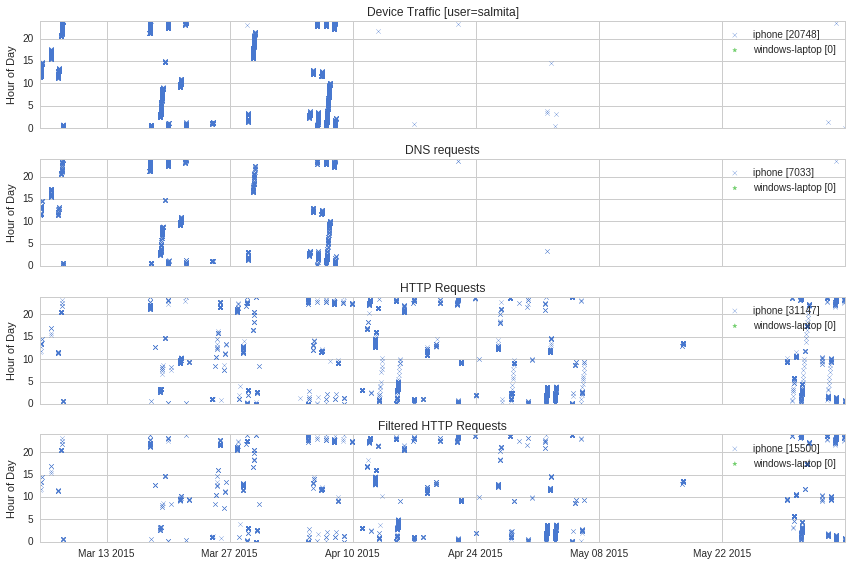

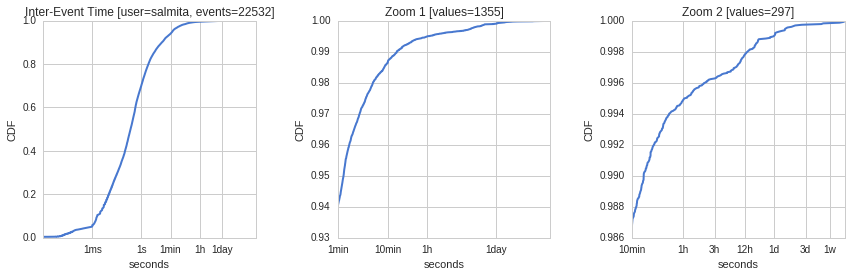

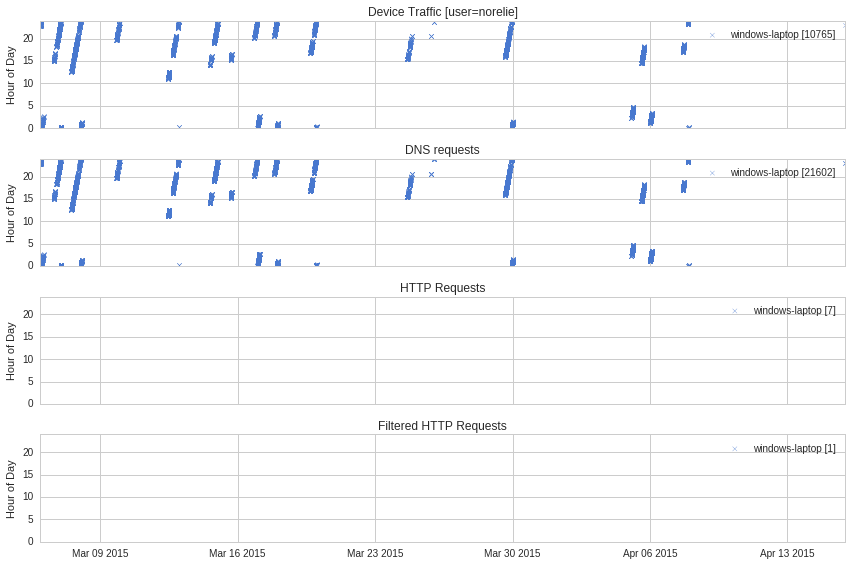

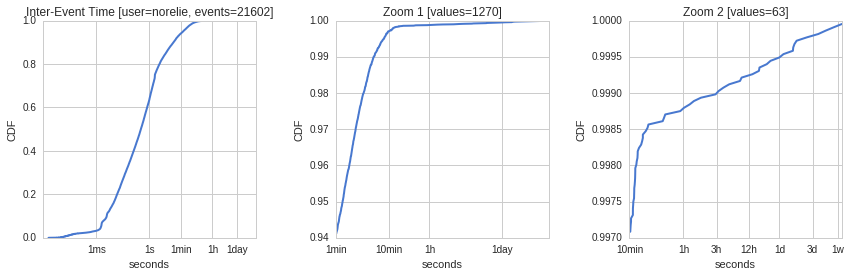

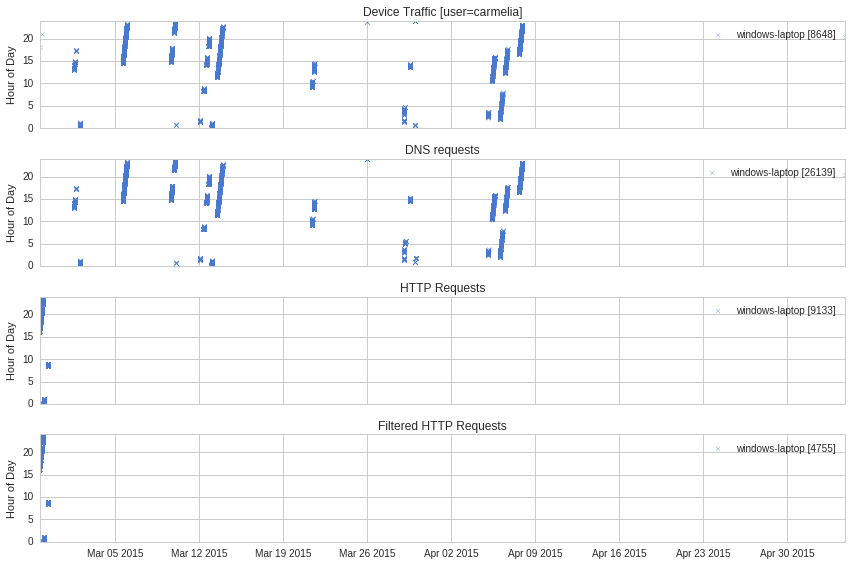

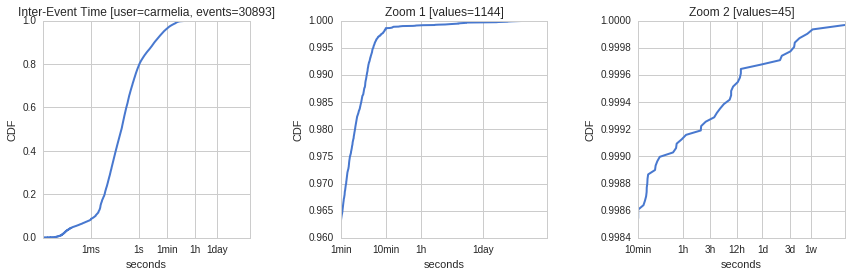

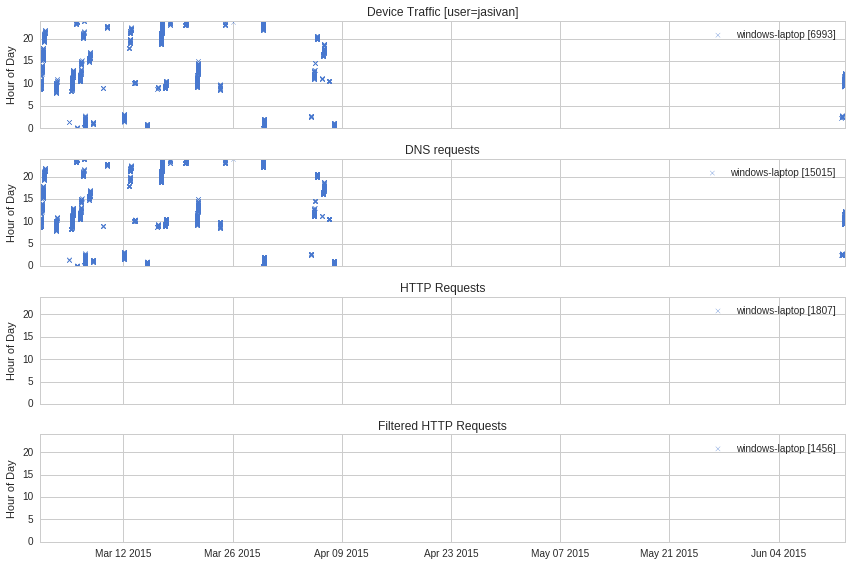

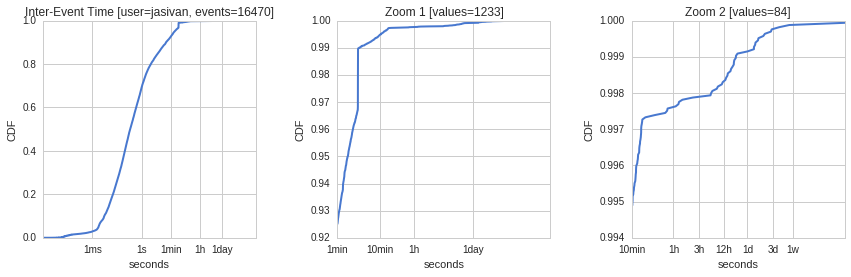

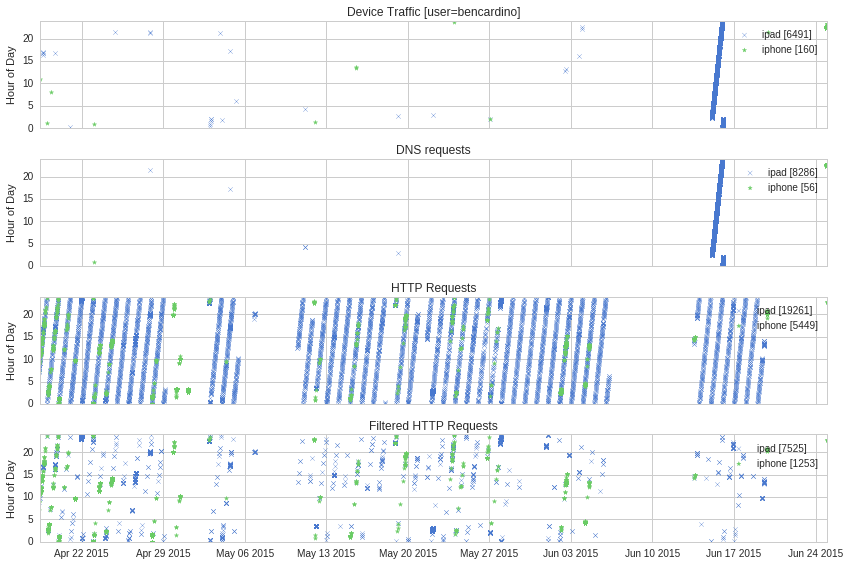

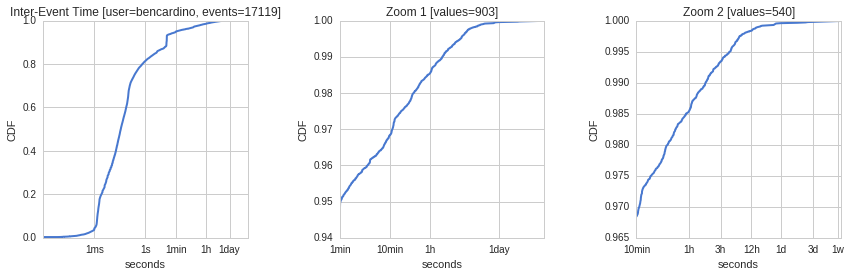

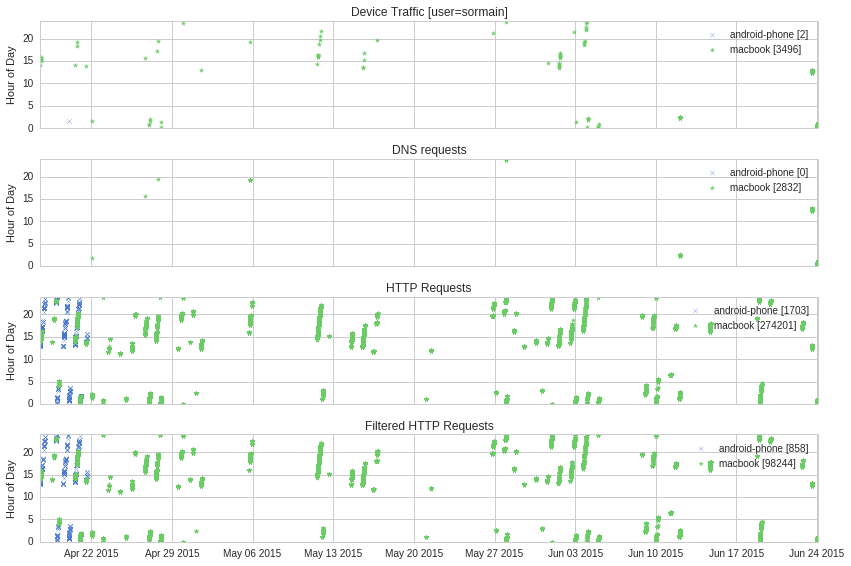

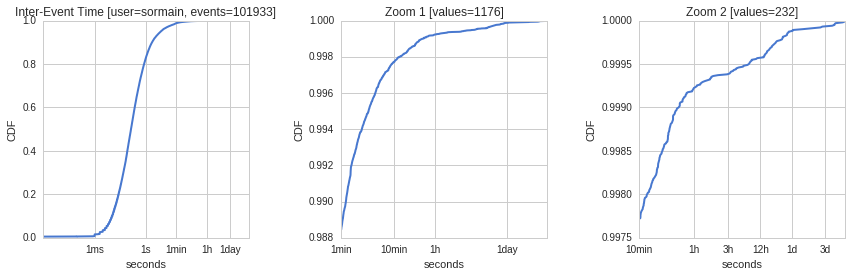

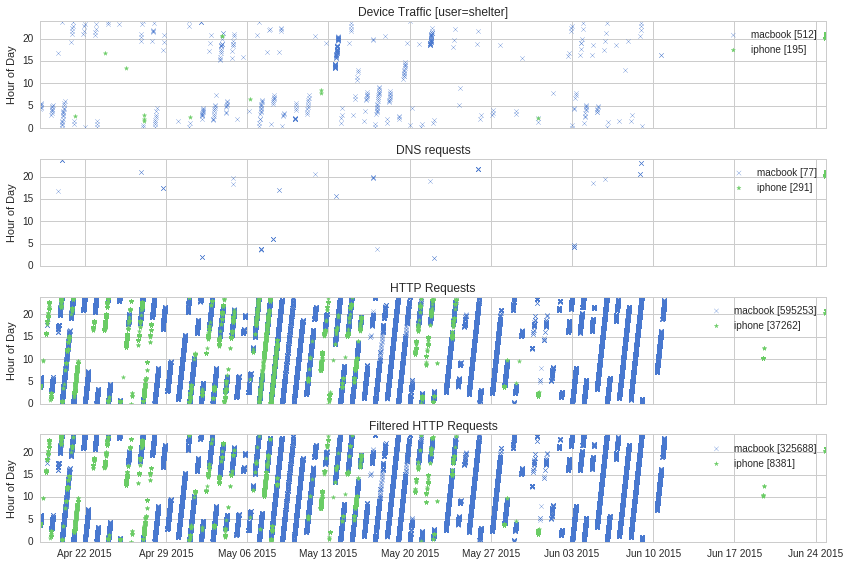

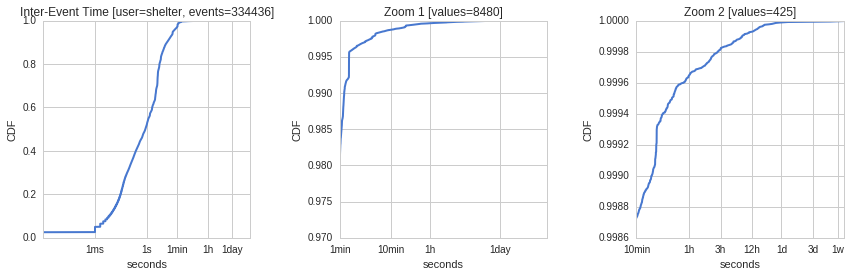

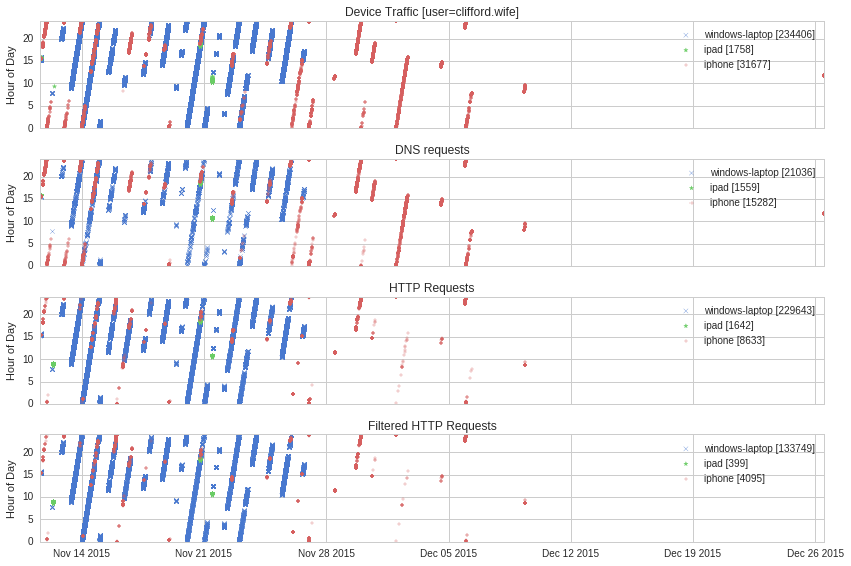

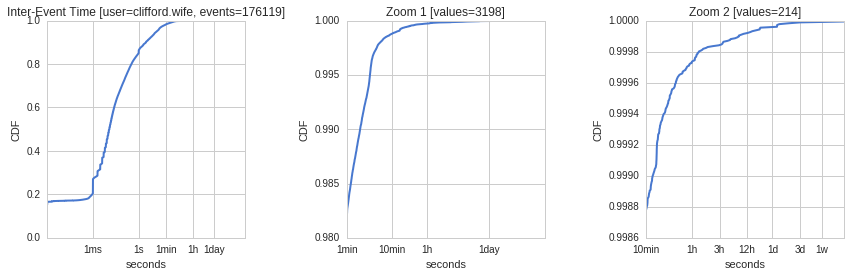

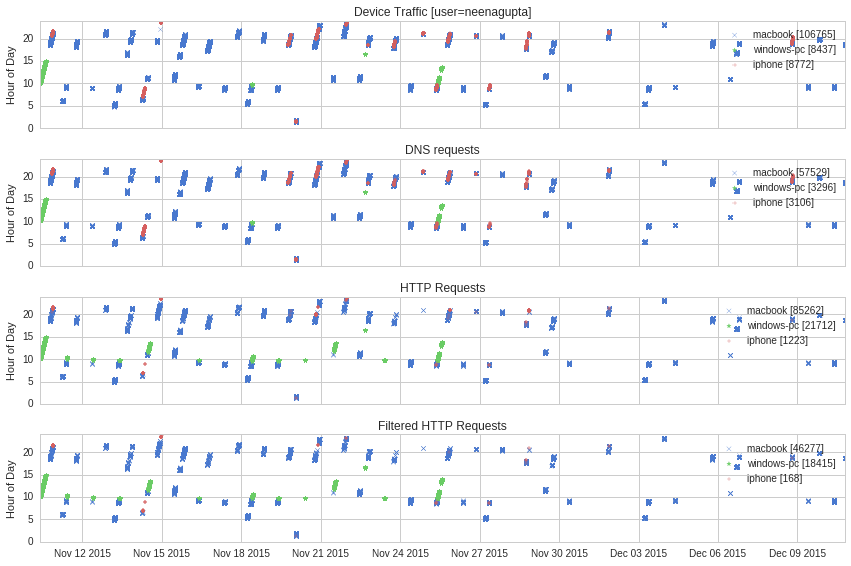

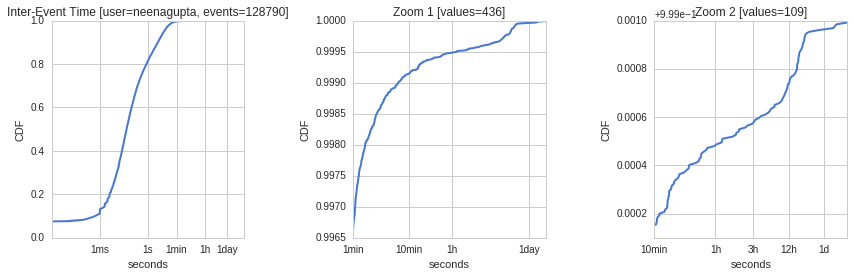

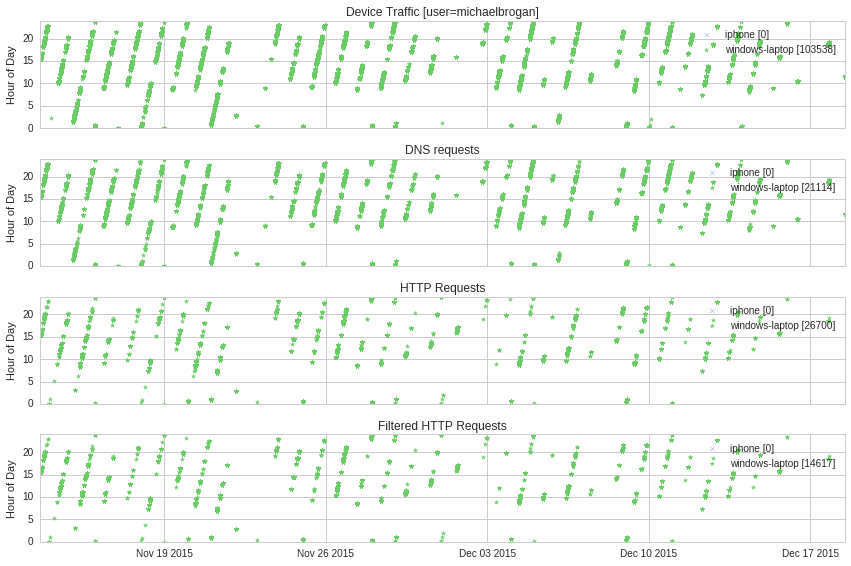

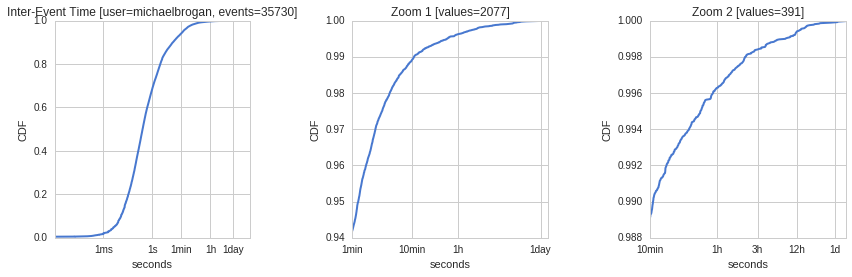

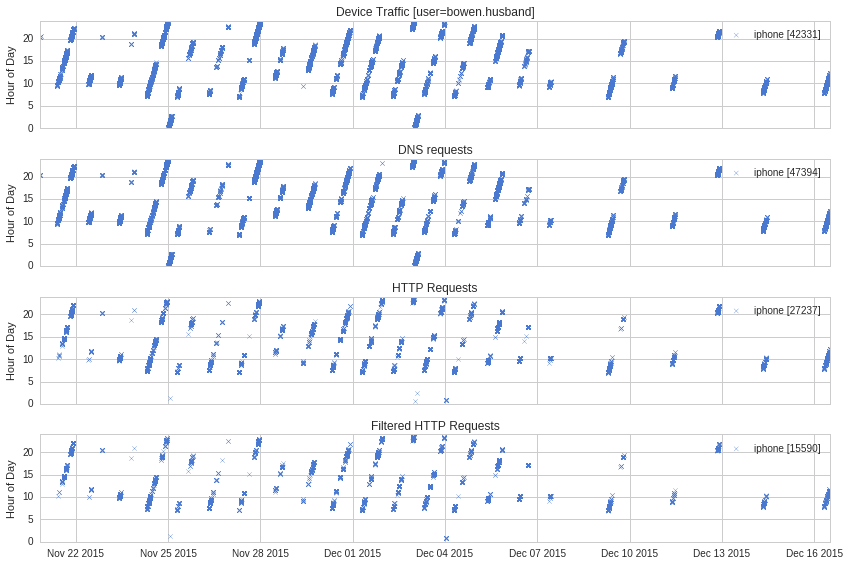

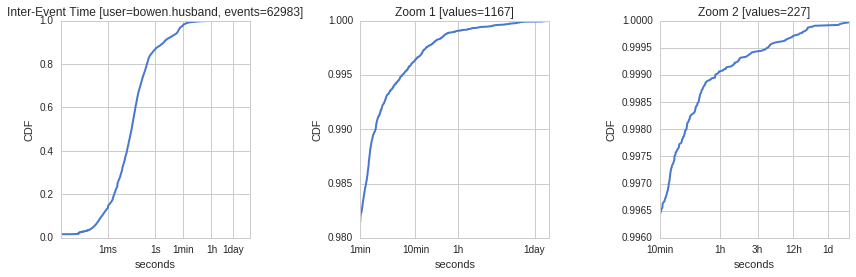

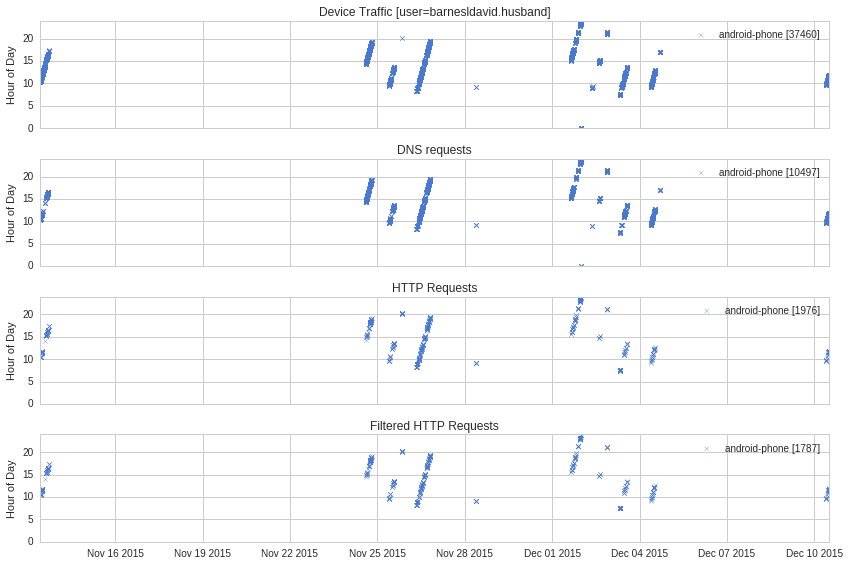

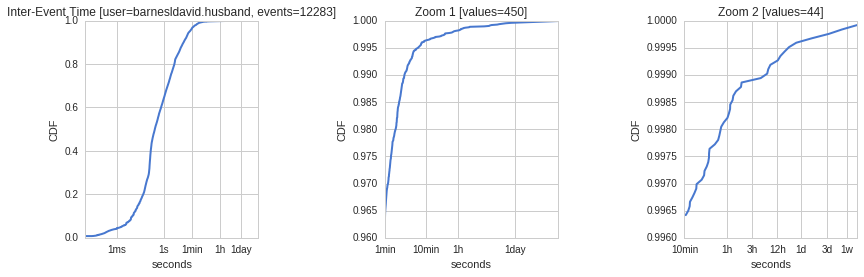

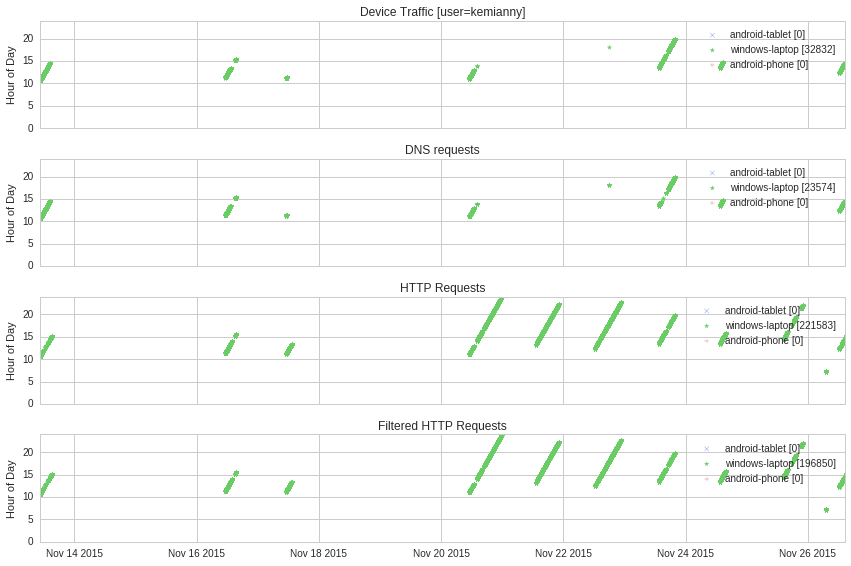

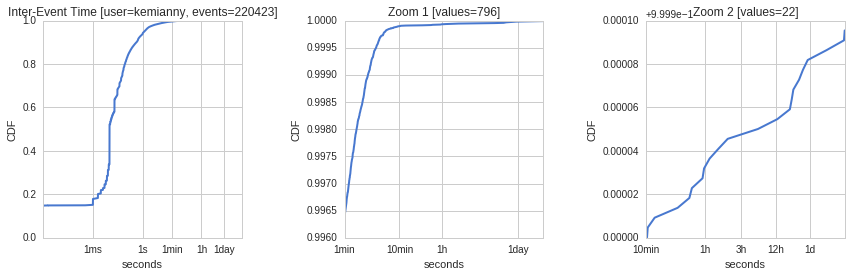

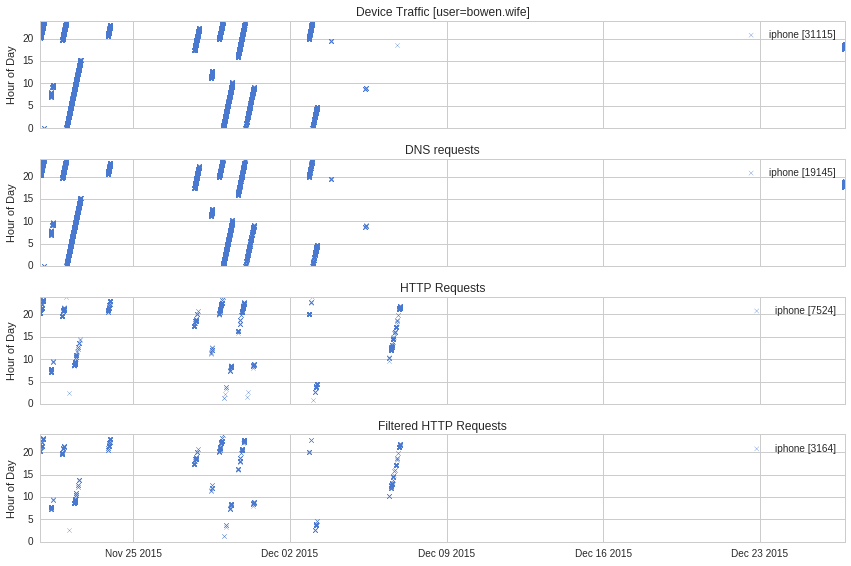

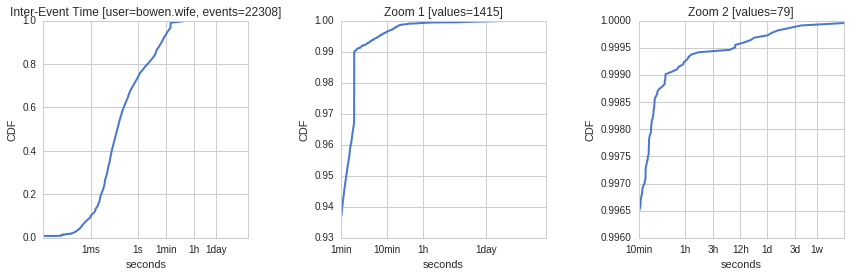

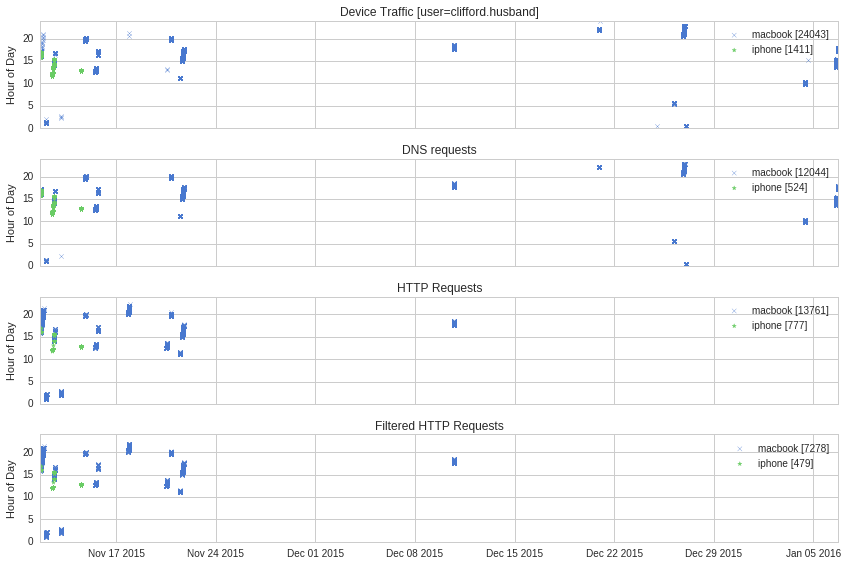

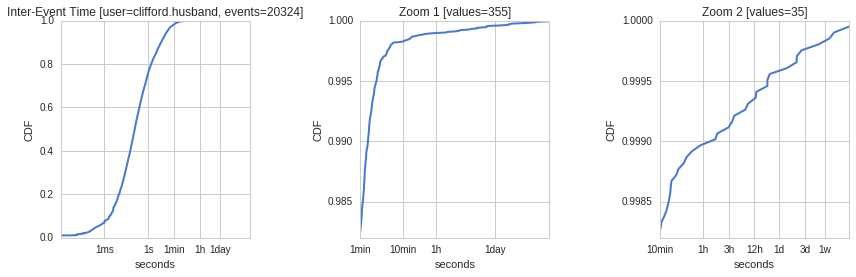

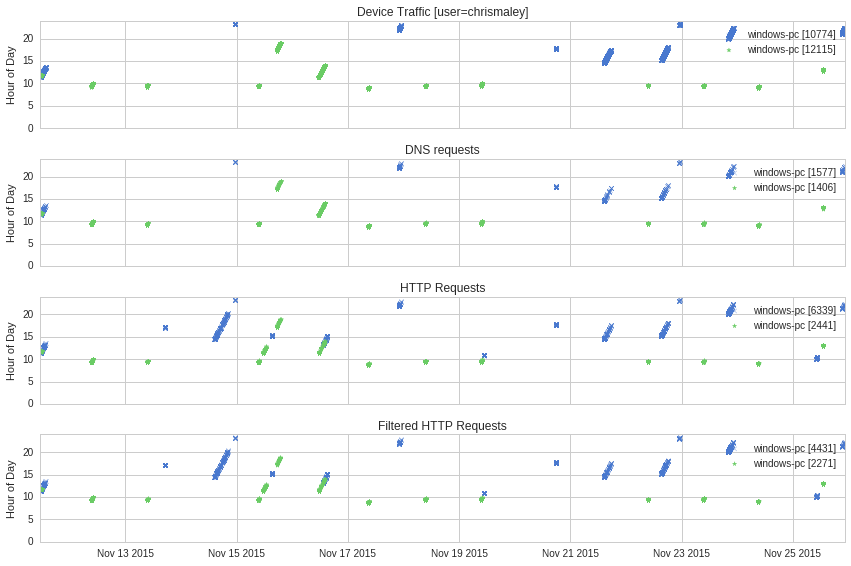

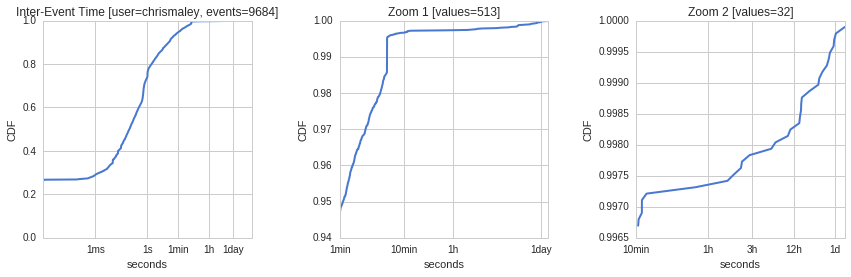

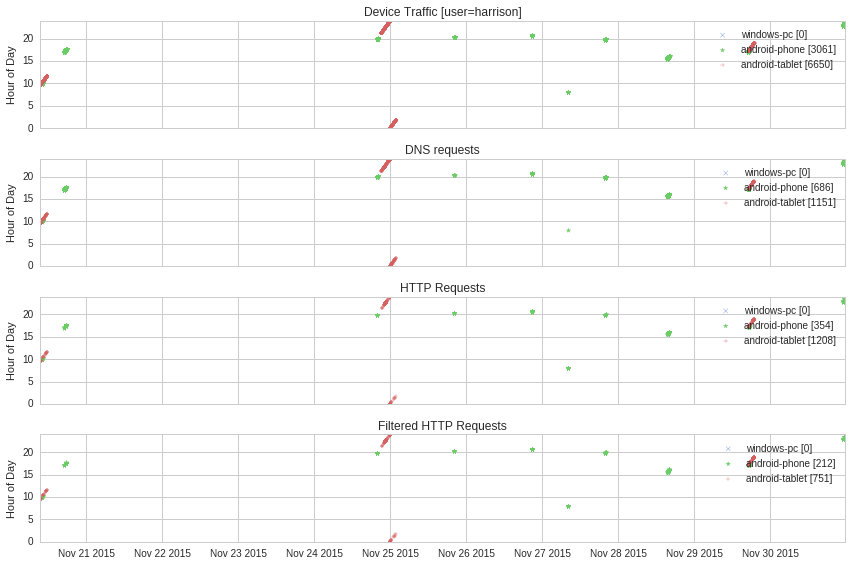

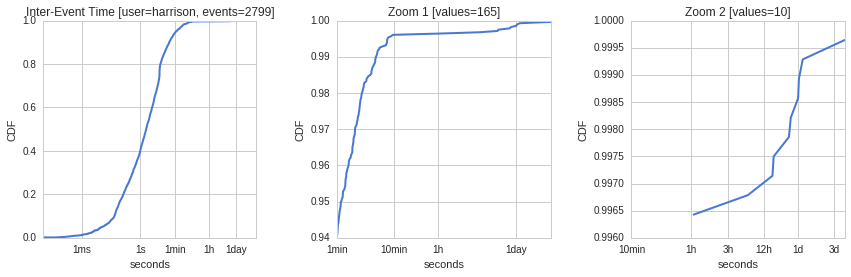

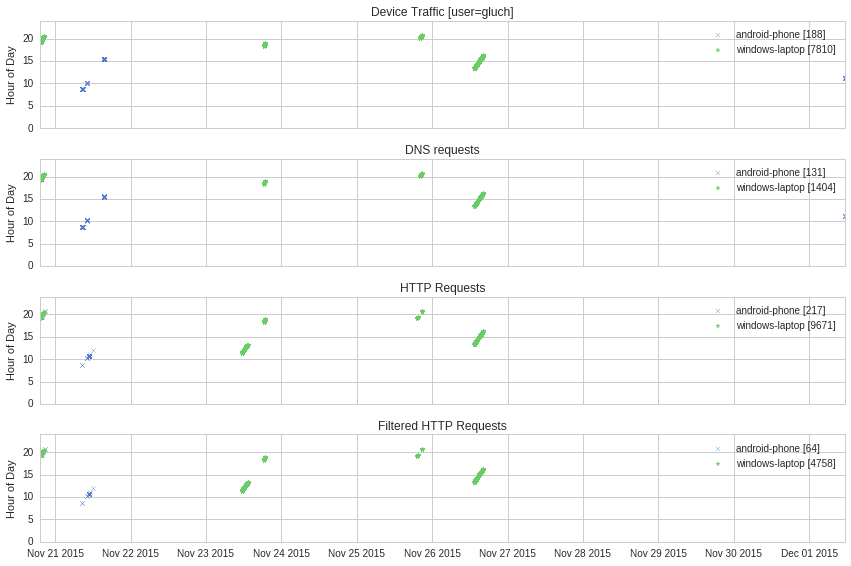

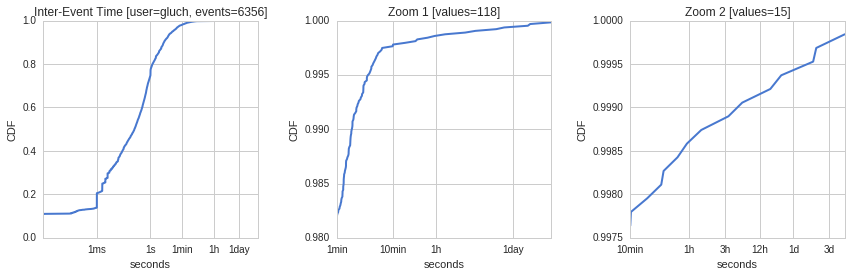

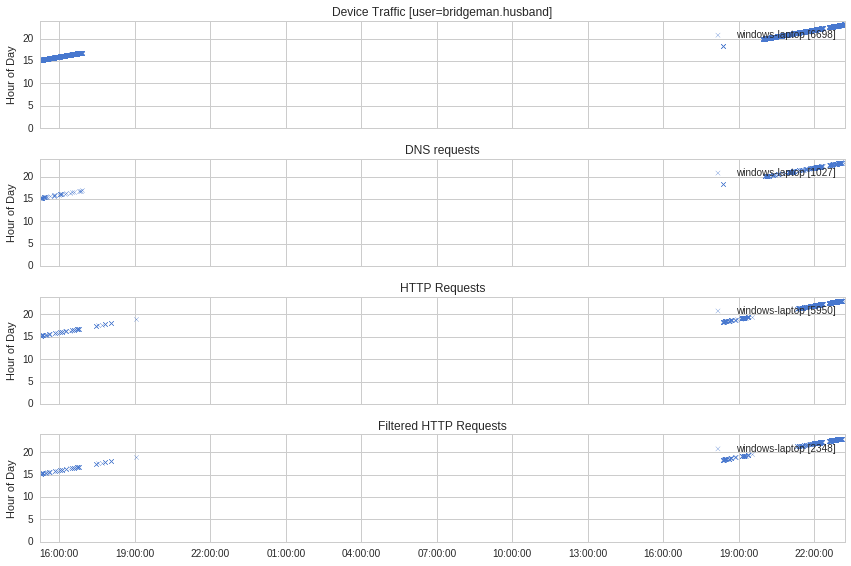

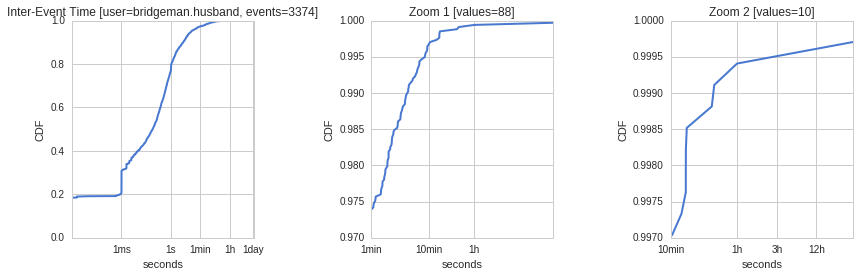

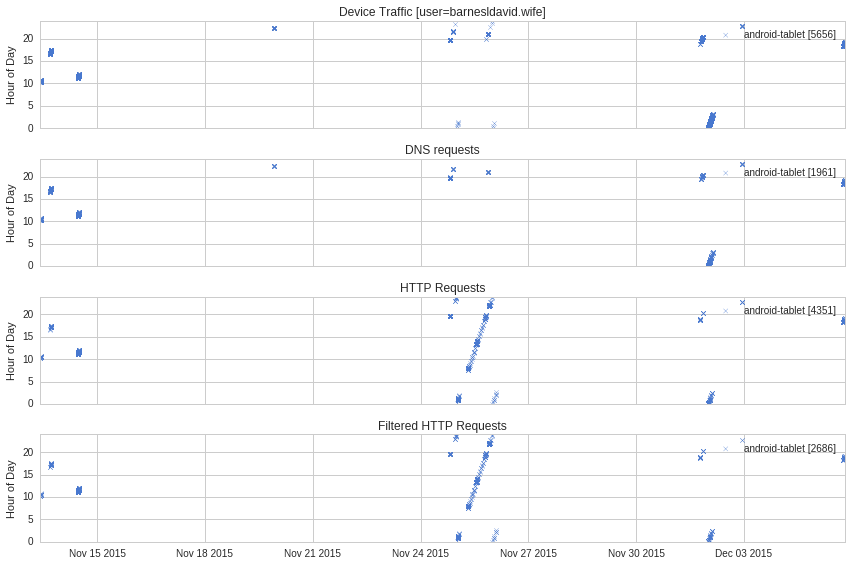

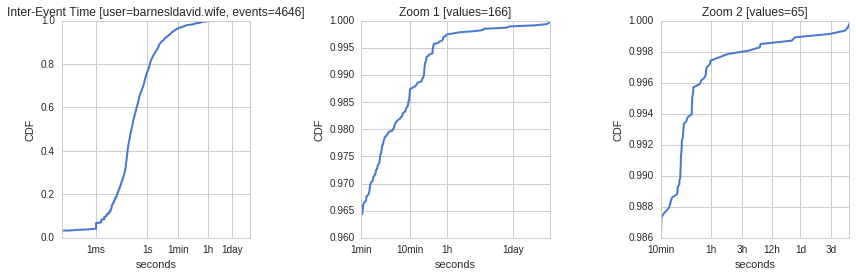

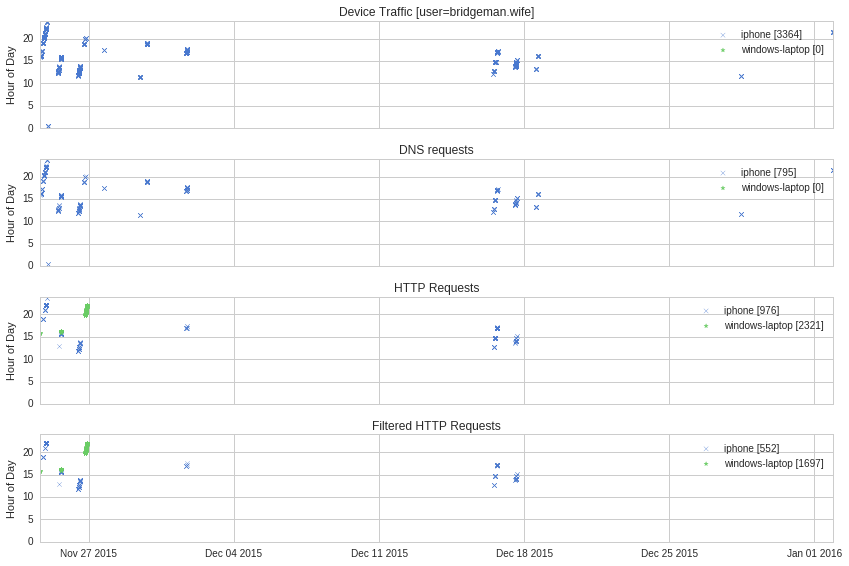

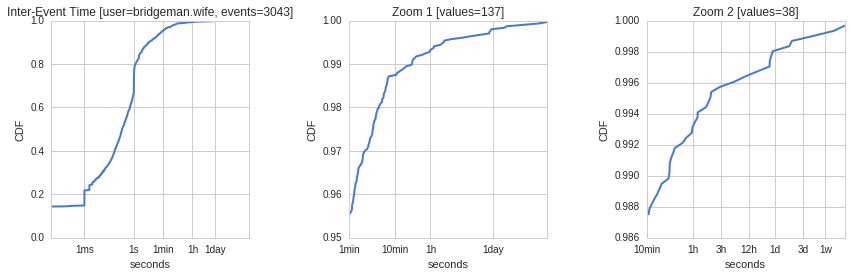

In [83]:
colors = sns.color_palette('muted')
sns.set_style("whitegrid")
markers = ['x','*','+','s','c']

dffr = df[df['country']=='fr'].sort_values('activetime (min)', ascending=False)
dfuk = df[df['country']=='uk'].sort_values('activetime (min)', ascending=False)

ses = Session()
for uname in list(dffr.loc[:,'username']) + list(dfuk.loc[:,'username']):
    u = ses.query(User).filter(User.username==uname).one()
    
    devids = ",".join([str(d.id) for d in u.devices if not d.shared])    

    devs = {}
    for d in u.devices:
        devs[d.id] = d.platform

    xstart = None
    xend = None
    samples = 0
    
    x = defaultdict(list)
    y = defaultdict(list)
    sqlq = """SELECT ts,devid FROM devicetraffic WHERE devid IN (%s) ORDER BY ts"""%(devids) 
    for row in ses.execute(text(sqlq)):
        ts = datautils.utctocc(row['ts'], u.country)
        
        if (xstart == None):
            xstart = ts
            xend = ts
        xstart = xstart if xstart < ts else ts
        xend = xend if xend > ts else ts
        
        x[row['devid']].append(ts)
        y[row['devid']].append(ts.hour+ts.minute/60.0)
        samples += 1

    # ignore users with less than 5min of observed traffic
    if (xstart == None or samples < 300):
        continue
        
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
    for i,devid in enumerate([d.id for d in u.devices if not d.shared]):
        ax1.scatter(x[devid], y[devid], marker=markers[i], color=colors[i], label='%s [%d]'%(devs[devid],len(x[devid])))
        
    ax1.set_title('Device Traffic [user=%s]'%(uname))    
    ax1.set_ylim((0,24))
    ax1.set_ylabel('Hour of Day')
    ax1.set_xlim(xstart,xend)
    ax1.legend(loc='best')

    x = defaultdict(list)
    y = defaultdict(list)
    sqlq = """SELECT ts,devid FROM dnsreqs WHERE devid IN (%s) ORDER BY ts"""%(devids)
    for row in ses.execute(text(sqlq)):
        ts = datautils.utctocc(row['ts'], u.country)        
        x[row['devid']].append(ts)
        y[row['devid']].append(ts.hour+ts.minute/60.0)
        
    for i,devid in enumerate([d.id for d in u.devices if not d.shared]):
        ax2.scatter(x[devid], y[devid], marker=markers[i], color=colors[i], label='%s [%d]'%(devs[devid],len(x[devid])))
    ax2.set_title('DNS requests')    
    ax2.set_ylabel('Hour of Day')
    ax2.set_ylim((0,24))
    ax2.legend(loc='best')
    
    x = defaultdict(list)
    y = defaultdict(list)
    sqlq = """SELECT ts,devid FROM httpreqs2 WHERE devid IN (%s) ORDER BY ts"""%(devids)
    for row in ses.execute(text(sqlq)):
        ts = datautils.utctocc(row['ts'], u.country)
        x[row['devid']].append(ts)
        y[row['devid']].append(ts.hour+ts.minute/60.0)
        
    for i,devid in enumerate([d.id for d in u.devices if not d.shared]):
        ax3.scatter(x[devid], y[devid], marker=markers[i], color=colors[i], label='%s [%d]'%(devs[devid],len(x[devid])))
    ax3.set_title('HTTP Requests')    
    ax3.set_ylabel('Hour of Day')
    ax3.set_xlim(xstart,xend)
    ax3.set_ylim((0,24))
    ax3.legend(loc='best')

    # filter urls
    x = defaultdict(list)
    y = defaultdict(list)
    sqlq = """SELECT ts,devid FROM httpreqs2 WHERE devid IN (%s) AND user_url = 't' ORDER BY ts"""%(devids)
    for row in ses.execute(text(sqlq)):
        ts = datautils.utctocc(row['ts'], u.country)
        x[row['devid']].append(ts)
        y[row['devid']].append(ts.hour+ts.minute/60.0)
        
    for i,devid in enumerate([d.id for d in u.devices if not d.shared]):
        ax4.scatter(x[devid], y[devid], marker=markers[i], color=colors[i], label='%s [%d]'%(devs[devid],len(x[devid])))
    ax4.set_title('Filtered HTTP Requests')    
    ax4.set_ylabel('Hour of Day')
    ax4.set_xlim(xstart,xend)
    ax4.set_ylim((0,24))
    ax4.legend(loc='best')
    
    plt.tight_layout()
    plt.show()
    
    # inter-event times
    iat = []
    
    sqlq = """SELECT ts,lag(ts) OVER (ORDER BY ts) FROM \
    (SELECT ts FROM dnsreqs WHERE devid IN (%s) UNION ALL \
     SELECT ts FROM httpreqs2 WHERE devid IN (%s) AND user_url = 't') \
    AS events"""%(devids,devids)
    
    for row in ses.execute(text(sqlq)):
        if (row[1]==None):
            continue
        iat.append((row[0]-row[1]).total_seconds())

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    (x,y) = datautils.aecdf(iat)
    ax1.plot(x,y, '-', lw=2, color=colors[0])
    ax1.set_title('Inter-Event Time [user=%s, events=%d]'%(uname, len(x)))    
    ax1.set_ylabel('CDF')
    ax1.set_xscale('log')
    ax1.set_xlabel('seconds')
    ax1.set_xticks([0.001,1,60,3600,24*3600])
    ax1.set_xticklabels(['1ms','1s','1min','1h','1day'])    
    ax2.set_xlim(0.001,max(iat))
    
    xp = filter(lambda v : v>=60, x)
    ax2.plot(xp,y[-len(xp):], '-', lw=2, color=colors[0])
    ax2.set_title('Zoom 1 [values=%d]'%(len(xp)))    
    ax2.set_ylabel('CDF')
    ax2.set_xscale('log')
    ax2.set_xlabel('seconds')
    ax2.set_xticks([60,600,3600,24*3600])
    ax2.set_xticklabels(['1min','10min','1h','1day'])        
    ax2.set_xlim(60,max(iat))

    xp = filter(lambda v : v>=600, x)
    ax3.plot(xp,y[-len(xp):], '-', lw=2, color=colors[0])
    ax3.set_title('Zoom 2 [values=%d]'%(len(xp)))    
    ax3.set_ylabel('CDF')
    ax3.set_xscale('log')
    ax3.set_xlabel('seconds')
    ax3.set_xticks([600,3600,3*3600,12*2600,24*3600,3*24*3600,7*24*3600])
    ax3.set_xticklabels(['10min','1h','3h','12h','1d','3d','1w'])        
    ax3.set_xlim(600,max(iat))
    
    plt.tight_layout()
    plt.show()            
    
ses.close()

In [ ]:
ses = Session()

# minutes
BINSIZE=120
        
weekdata = []
for uid in sorted(usertraffic, key=lambda x : usertraffic[x], reverse=True):
    weektotal = 0.0
    weekdays = {}
    for k in range(0,7*24*60,BINSIZE):
        k = k/BINSIZE
        weekdays[k] = 0.0

    q = ses.query(DeviceAppTraffic.ts, 
                  DeviceAppTraffic.bytes_in, 
                  DeviceAppTraffic.bytes_out).filter(
                    DeviceAppTraffic.devid.in_(devsperuser[uid]))
    
    for (ts,byin,byout) in q.all():
        bytes = 0
        if (byin!=None):
            bytes += byin
        if (byout!=None):
            bytes += byout
            
        timeofday = ts.weekday()*24*60 + ts.hour*60 + ts.minute
        binidx = timeofday/BINSIZE
        
        weekdays[binidx] += bytes
        weektotal += bytes
            
    # to % of bytes
    for k in range(0,7*24*60,BINSIZE):
        k = k/BINSIZE
        if (weektotal>0):
            weekdays[k] = 100.0*(weekdays[k]*1.0/weektotal)

    weekdata.append(weekdays.values())
        
cmap = sns.dark_palette("#ffffff", as_cmap=True, reverse=True)
f, ax = plt.subplots(1, 1, figsize=(12, 4))
ax = sns.heatmap(weekdata, 
                 cmap=cmap,
                 vmin=0, 
                 vmax=100.0, 
                 linewidths=.5, 
                 xticklabels=12,
                 yticklabels=False)

ax.set_title("Network Activity")
ax.set_ylabel("Participant")
ax.set_xlabel("")
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], rotation=0)
plt.show()

# TODO: app activity

ses.close()

In [ ]:
ses = Session()

# uid => total traffic
usertraffic = {}
for uid in devsperuser:
    usertraffic[uid] = 0.0
    
    q = ses.query(func.sum(DeviceAppTraffic.bytes_in), 
                  func.sum(DeviceAppTraffic.bytes_out), 
                  func.sum(DeviceAppTraffic.packets_in), 
                  func.sum(DeviceAppTraffic.packets_out)).filter(
                    DeviceAppTraffic.devid.in_(devsperuser[uid]))

    for row in q.all():
        if (row[0]==None or row[1]==None or row[0]+row[1]==0):
            continue
        usertraffic[uid] += row[0]*1.0
        usertraffic[uid] += row[1]*1.0
        
print usertraffic.keys()

cmap = sns.dark_palette("#ffffff", as_cmap=True, reverse=True)

# minutes
BINSIZE=60
        
weekdata = []
wedata = []
alldata = []

for uid in sorted(usertraffic, key=lambda x : usertraffic[x], reverse=True):
    weektotal = 0.0
    wetotal = 0.0
    alltotal = 0.0
    weekdays = {}
    weekend = {}
    alldays = {}
    for k in range(0,24*60,BINSIZE):
        k = k/BINSIZE
        weekdays[k] = 0.0
        weekend[k] = 0.0
        alldays[k] = 0.0

    q = ses.query(DeviceAppTraffic.ts, 
                  DeviceAppTraffic.bytes_in, 
                  DeviceAppTraffic.bytes_out).filter(
                    DeviceAppTraffic.devid.in_(devsperuser[uid]))
    
    for (ts,byin,byout) in q.all():
        bytes = 0
        if (byin!=None):
            bytes += byin
        if (byout!=None):
            bytes += byout
            
        timeofday = ts.hour*60 + ts.minute
        binidx = timeofday/BINSIZE
        
        if (ts.weekday() == 5 or ts.weekday() == 6):
            weekend[binidx] += bytes
            wetotal += bytes
        else:
            weekdays[binidx] += bytes
            weektotal += bytes
            
        alldays[binidx] += bytes
        alltotal += bytes
            
    # to % of bytes
    for k in range(0,24*60,BINSIZE):
        k = k/BINSIZE
        if (weektotal>0):
            weekdays[k] = 100.0*(weekdays[k]*1.0/weektotal)
        if (wetotal>0):
            weekend[k] = 100.0*(weekend[k]*1.0/wetotal)
        if (alltotal>0):
            alldays[k] = 100.0*(alldays[k]*1.0/alltotal)

    weekdata.append(weekdays.values())
    wedata.append(weekend.values())
    alldata.append(alldays.values())
        
# Network Activity Heatmap [weekday|weekend]: x: time-of-day, y: user, intensity: % of bytes (from this user)
ax = sns.heatmap(weekdata, 
                 cmap=cmap,
                 square=True,
                 vmin=0, 
                 vmax=100.0, 
                 linewidths=.5, 
                 yticklabels=False)
ax.set_title("Network Activity During Week Days")
ax.set_ylabel("Participant")
ax.set_xlabel("Hour-of-day")
plt.show()

ax = sns.heatmap(wedata, 
                 cmap=cmap,
                 square=True,
                 vmin=0, 
                 vmax=100.0, 
                 linewidths=.5, 
                 yticklabels=False)
ax.set_title("Network Activity During Weekends")
ax.set_ylabel("Participant")
ax.set_xlabel("Hour-of-day")
plt.show()

ax = sns.heatmap(alldata, 
                 cmap=cmap,
                 square=True,
                 vmin=0, 
                 vmax=100.0, 
                 linewidths=.5, 
                 yticklabels=False)
ax.set_title("Network Activity")
ax.set_ylabel("Participant")
ax.set_xlabel("Hour-of-day")
plt.show()

# App (DNS+HTTP) Activity Heatmap [weekday|weekend]: x: time-of-day, y: user, intensity: % of reqs (from this user)

weekdata = []
wedata = []
alldata = []

for uid in sorted(usertraffic, key=lambda x : usertraffic[x], reverse=True):
    weektotal = 0.0
    wetotal = 0.0
    alltotal = 0.0
    weekdays = {}
    weekend = {}
    alldays = {}
    for k in range(0,24*60,BINSIZE):
        k = k/BINSIZE
        weekdays[k] = 0.0
        weekend[k] = 0.0
        alldays[k] = 0.0

    q = ses.query(HttpReq.ts).filter(
                    HttpReq.devid.in_(devsperuser[uid])).filter(
                    HttpReq.user_url==True)    
    for row in q.all():
        ts = row[0]
        timeofday = ts.hour*60 + ts.minute
        binidx = timeofday/BINSIZE
        
        if (ts.weekday() == 5 or ts.weekday() == 6):
            weekend[binidx] += 1
            wetotal += 1
        else:
            weekdays[binidx] += 1
            weektotal += 1
            
        alldays[binidx] += 1
        alltotal += 1

    q = ses.query(DnsReq.ts).filter(
                    DnsReq.devid.in_(devsperuser[uid])).filter(
                    DnsReq.user_req==True) 
    for row in q.all():
        ts = row[0]
        timeofday = ts.hour*60 + ts.minute
        binidx = timeofday/BINSIZE
        
        if (ts.weekday() == 5 or ts.weekday() == 6):
            weekend[binidx] += 1
            wetotal += 1
        else:
            weekdays[binidx] += 1
            weektotal += 1
            
        alldays[binidx] += 1
        alltotal += 1
        
        
    # to % of bytes
    for k in range(0,24*60,BINSIZE):
        k = k/BINSIZE
        if (weektotal>0):
            weekdays[k] = 100.0*(weekdays[k]*1.0/weektotal)
        if (wetotal>0):
            weekend[k] = 100.0*(weekend[k]*1.0/wetotal)
        if (alltotal>0):
            alldays[k] = 100.0*(alldays[k]*1.0/alltotal)

    weekdata.append(weekdays.values())
    wedata.append(weekend.values())
    alldata.append(alldays.values())
        
# User App Activity Heatmap [weekday|weekend]: x: time-of-day, y: user, intensity: % of bytes (from this user)
ax = sns.heatmap(weekdata, 
                 cmap=cmap,
                 square=True,
                 vmin=0, 
                 vmax=100.0, 
                 linewidths=.5, 
                 yticklabels=False)
ax.set_title("User Activity During Week Days")
ax.set_ylabel("Participant")
ax.set_xlabel("Hour-of-day")
plt.show()

ax = sns.heatmap(wedata, 
                 cmap=cmap,
                 square=True,
                 vmin=0, 
                 vmax=100.0, 
                 linewidths=.5, 
                 yticklabels=False)
ax.set_title("User Activity During Weekends")
ax.set_ylabel("Participant")
ax.set_xlabel("Hour-of-day")
plt.show()

ax = sns.heatmap(alldata, 
                 cmap=cmap,
                 square=True,
                 vmin=0, 
                 vmax=100.0, 
                 linewidths=.5, 
                 yticklabels=False)
ax.set_title("User Activity")
ax.set_ylabel("Participant")
ax.set_xlabel("Hour-of-day")
plt.show()

ses.close()

## User Activity

Activity = period of events that occur < 10min apart. Properties:

* Time of day
* Duration (start - end)
* Device(s) - could span multiple devices
* Network(s)
* Where ? Should I guess be limited to a single location (ignore mobility for now ?)
* What ? Set of unique domain names
* Apps ? Set of unique user agents (or list of running / active apps from hostview or android)

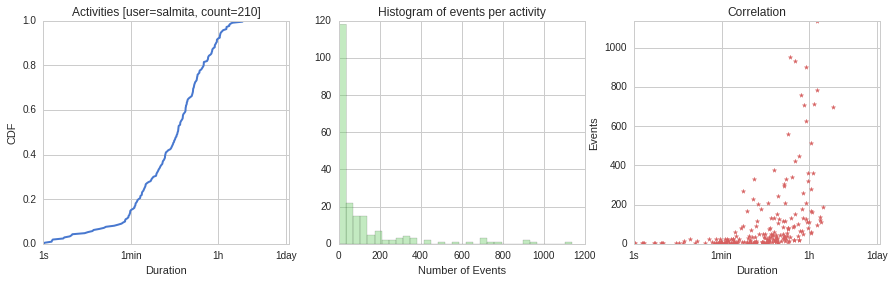

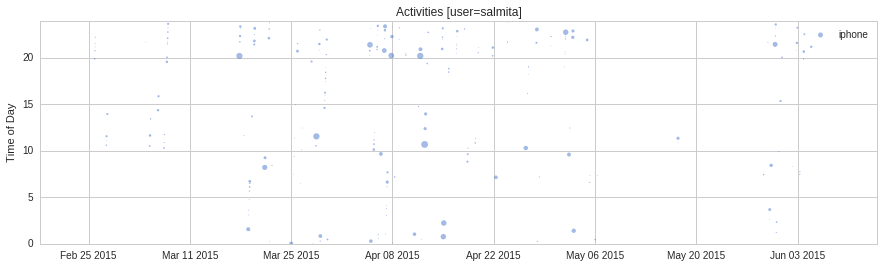

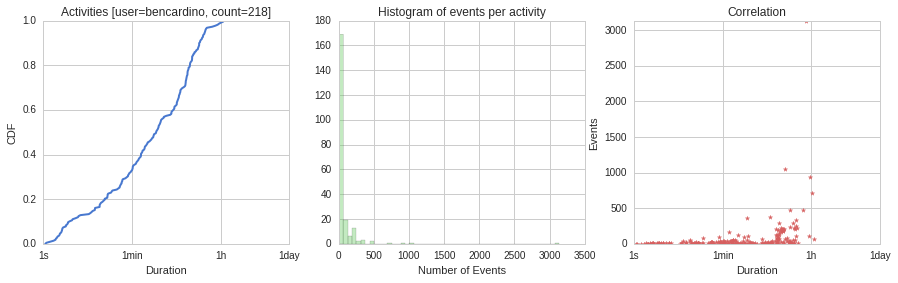

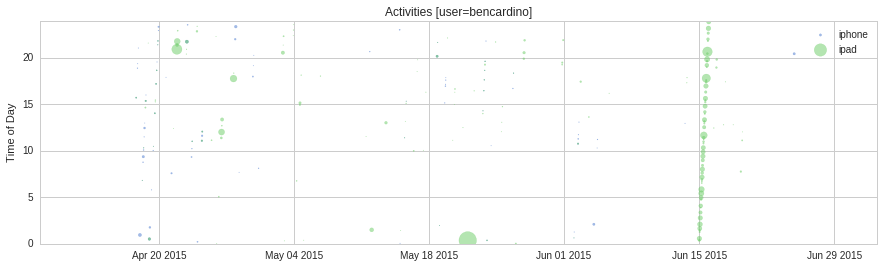

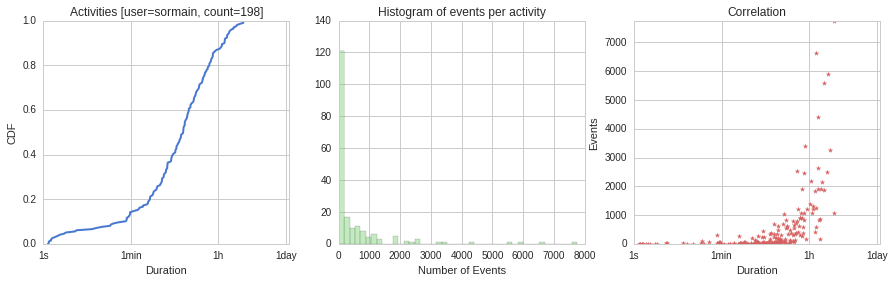

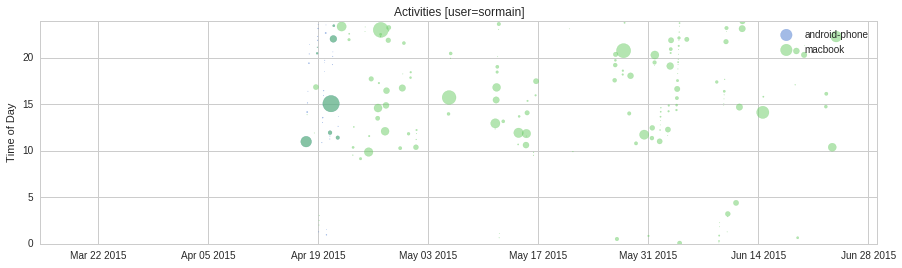

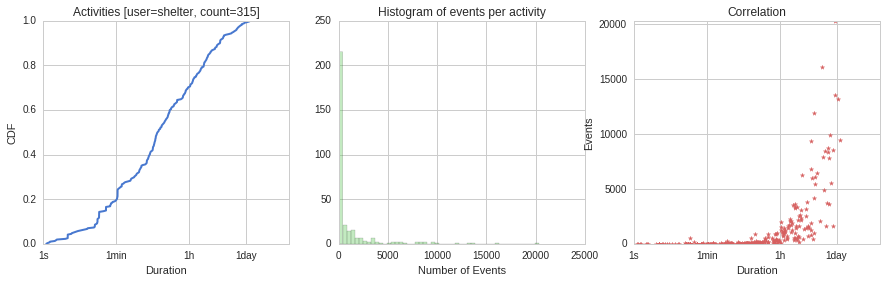

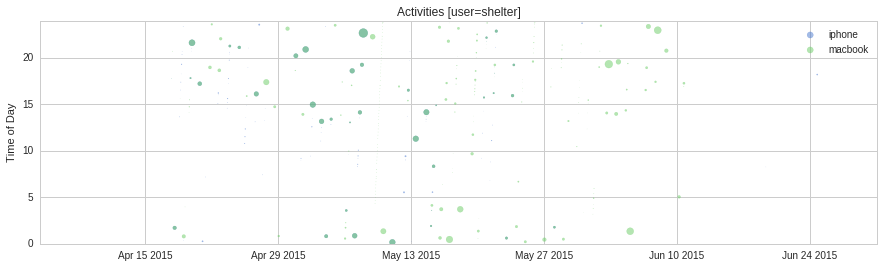

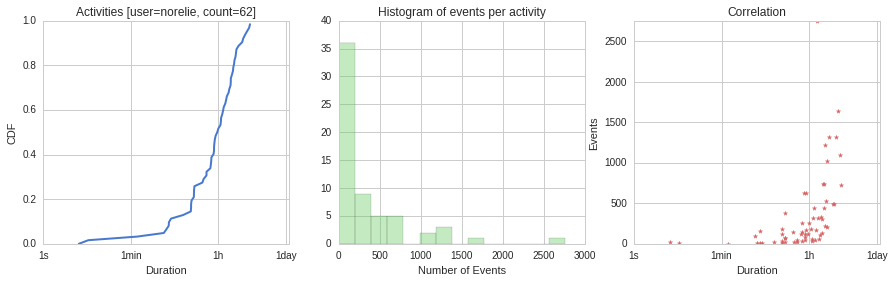

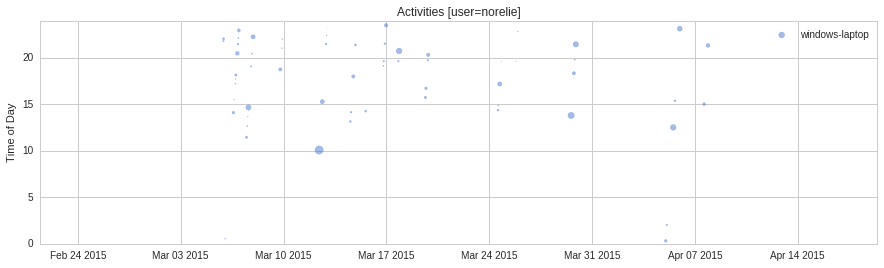

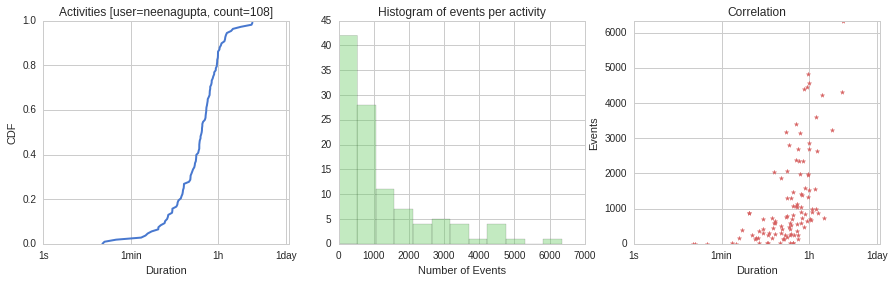

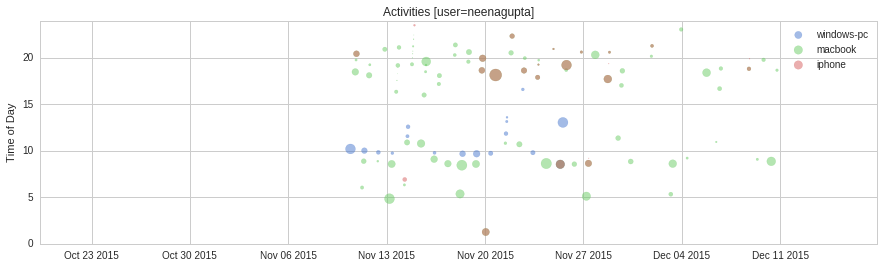

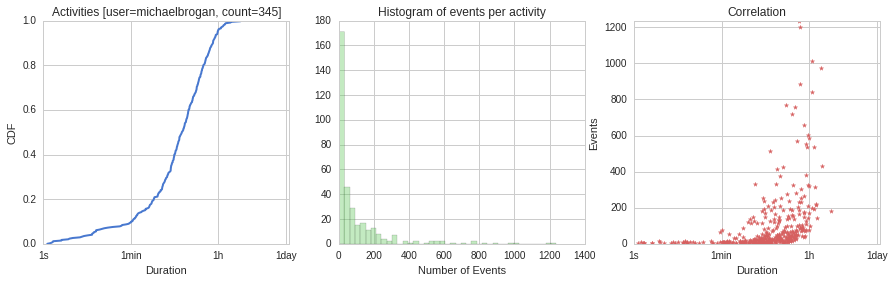

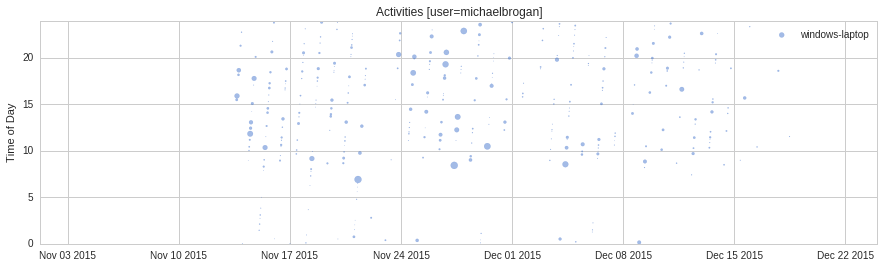

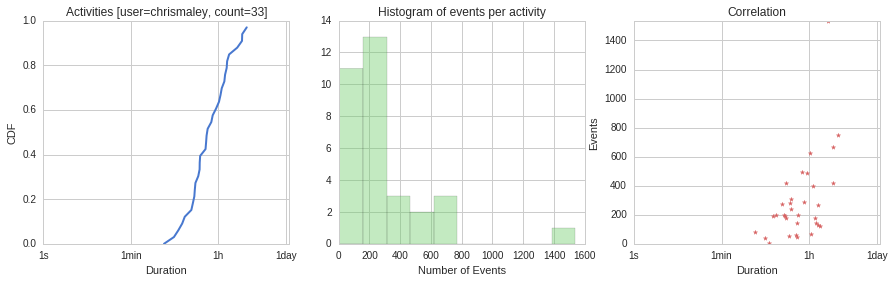

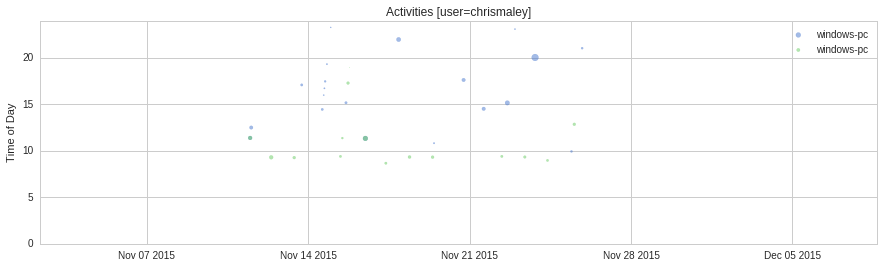

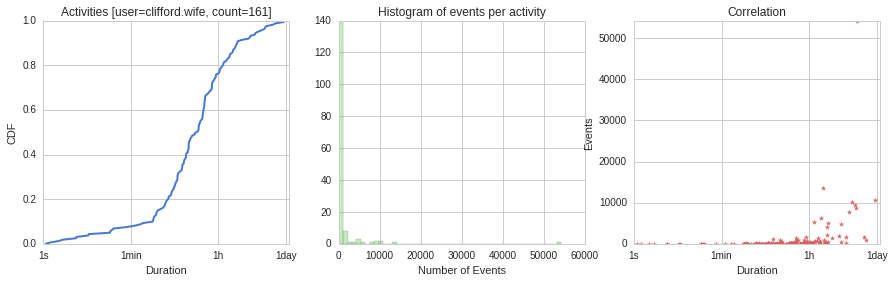

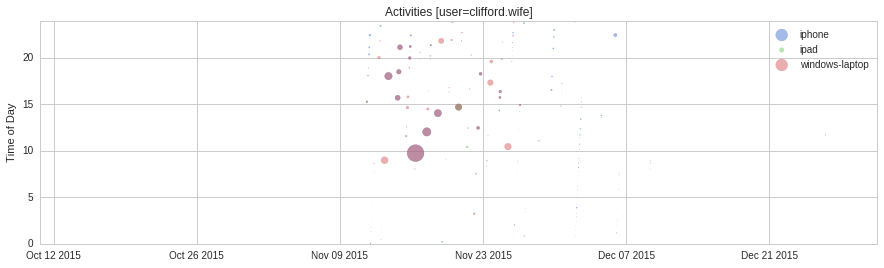

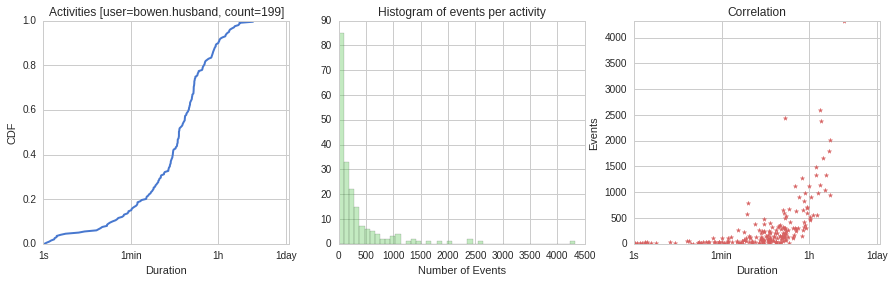

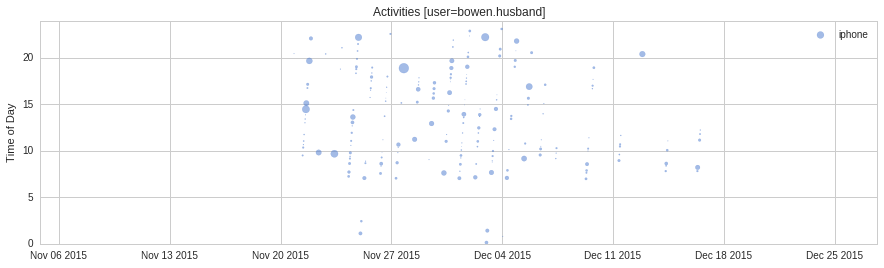

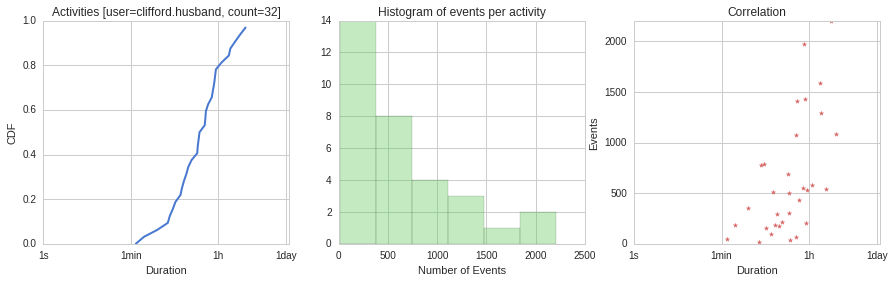

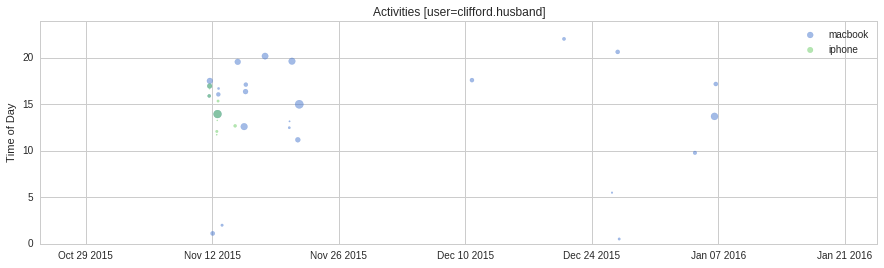

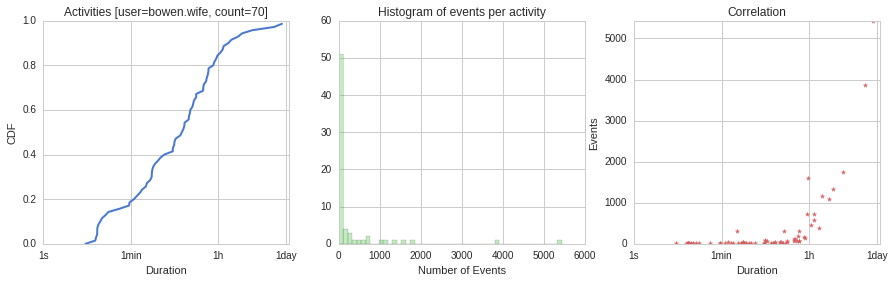

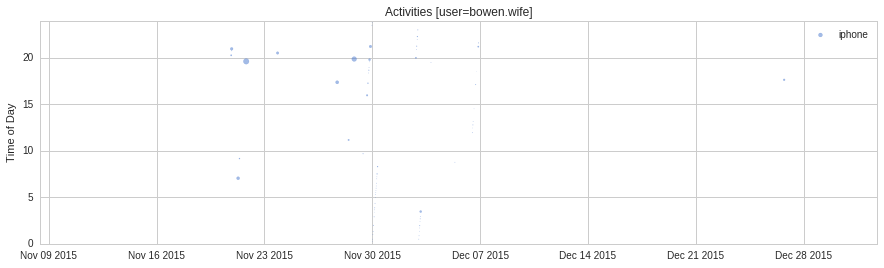

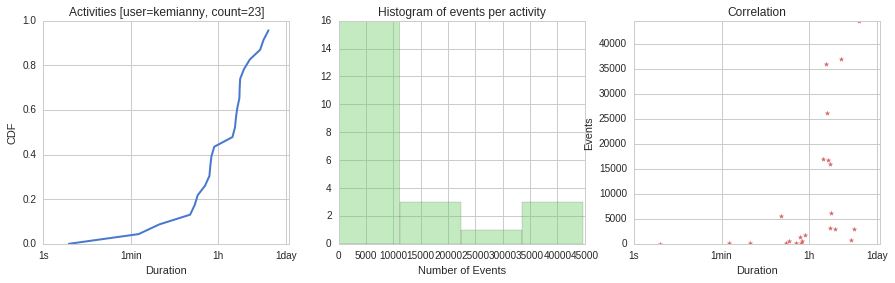

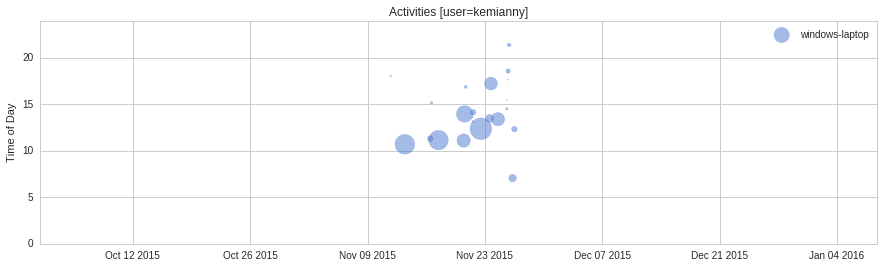

In [89]:
# top users based on above graphs
frusers = ['salmita', 'bencardino','sormain', 'shelter', 'norelie']
ukusers = ['neenagupta', 'michaelbrogan', 'chrismaley', 'clifford.wife', 'bowen.husband', 'clifford.husband', 'bowen.wife', 'kemianny']

# build per user activities: username - > list of tuples (starttime, endtime)
activities = defaultdict(list)

# in seconds (10min)
inactivitylim = 600
minduration = 1.0
minevents = 2

ses = Session()
for uname in list(frusers) + list(ukusers):
    u = ses.query(User).filter(User.username==uname).one()    
    devids = ",".join([str(d.id) for d in u.devices if not d.shared]) 
    
    sqlq = """SELECT ts,lag(ts) OVER (ORDER BY ts) FROM \
    (SELECT ts FROM dnsreqs WHERE devid IN (%s) UNION ALL \
     SELECT ts FROM httpreqs2 WHERE devid IN (%s) AND user_url = 't') \
    AS events"""%(devids,devids)

    start = None
    last = None
    ecnt = 0
    for row in ses.execute(text(sqlq)):
        if (row[1]==None):
            start = row[0]
            last = start
            continue
                
        dur = (row[1]-start).total_seconds()
        if ((row[0]-row[1]).total_seconds() > activitylim):
            if (dur >= minduration and ecnt > minevents):
                activities[uname].append((start,row[1],dur,ecnt))
            start = row[0]
            ecnt = 0
        last = row[0]
        ecnt += 1
        
    dur = (last-start).total_seconds()
    if (dur >= minduration and ecnt > minevents):
        activities[uname].append((start,last,dur,ecnt))

    # duration CDF
    (x,y) = datautils.aecdf([t[2] for t in activities[uname]])
        
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    ax1.plot(x,y, '-', lw=2, color=colors[0])
    ax1.set_title('Activities [user=%s, count=%d]'%(uname, len(x)))    
    ax1.set_ylabel('CDF')
    ax1.set_xscale('log')
    ax1.set_xlabel('Duration')
    ax1.set_xticks([1,60,3600,24*3600])
    ax1.set_xticklabels(['1s','1min','1h','1day'])    
    
    # num events
    ecnt = np.array(sorted([t[3] for t in activities[uname]], reverse=True))
    
    sns.distplot(ecnt, ax=ax2, color=colors[1], kde=False)    
    ax2.set_title('Histogram of events per activity')
    ax2.set_xlabel('Number of Events')    

    data = [(t[2],t[3]) for t in activities[uname]]
    
    maxdur = max([t[0] for t in data])
    maxcnt = max([t[1] for t in data])
    
    ax3.set_title('Correlation')    
    ax3.scatter([t[0] for t in data], [t[1] for t in data], marker='*', color=colors[2])

    ax3.set_xscale('log')
    ax3.set_xlabel('Duration')
    ax3.set_xticks([1,60,3600,24*3600])
    ax3.set_xticklabels(['1s','1min','1h','1day'])        
    
    ax3.set_ylabel('Events')
    ax3.set_ylim(0,maxcnt)    
    
    plt.show()

    # color activity per device
    devs = {}
    for d in u.devices:
        if (d.shared):
            continue
        devs[d.id] = d.platform
    
    # devid => activities
    data = defaultdict(list)
    for t in activities[uname]:
        # devices that sent http reqs during this activity
        q1 = ses.query(HttpReq.devid).filter(HttpReq.devid.in_(devs.keys()), 
                                             HttpReq.user_url==True, 
                                             HttpReq.ts >= t[0], 
                                             HttpReq.ts < t[1])
        # devices that sent dns reqs during this activity
        q2 = ses.query(DnsReq.devid).filter(DnsReq.devid.in_(devs.keys()), 
                                            DnsReq.ts >= t[0], 
                                            DnsReq.ts < t[1])
        # all unique devices
        for d in q1.union(q2).all():
            data[d[0]].append((t[0],t[2],t[3]))
        
    f, (ax1) = plt.subplots(1, 1, figsize=(15, 4))
    
    for idx,devid in enumerate(data.keys()):
        x = [t[0] for t in data[devid]] # starttime
        y = [t[0].hour + t[0].minute/60.0 for t in data[devid]] # hour-of-day 
        sizes = [(t[2]*400.0)/maxdur for t in data[devid]] # scale size of the marker to duration
        
        ax1.scatter(x, y, alpha=0.5, color=colors[idx], s=sizes, label="%s"%devs[devid])
        
    ax1.set_title('Activities [user=%s]'%(uname))    
    ax1.set_ylabel('Time of Day')
    ax1.set_ylim(0,24)
    ax1.legend(loc='best')    
ses.close()

## Dissecting QoE Factors

Characterize the activities as a function of the QoE factors. How varying is the (QoE) context in the end ?

### User

#### Demographics
#### Interests
#### Mood

=> Do the characterization per user, do not have enough data for breaking down per demographics and we do not know so much about their mood or interests either (could get something from the interviews ?)

### System Factors

#### Device

* device type: phone, tablet, laptop, PC (proxy for screen size, capacity etc.)
* usage: shared or personal

=> Are some activites device specific ? Some others independent ? Span multiple devices ?


#### Network and QoS

* mobile, home (adsl, other), work | wifi or fixed

=> Are some activities network specific ?

* RTT: device - VPN - internet (access delay depends on above, former could proxy congestion)
* Losses: up/down retransmissions, dupl ACKs, 
* bulk vs app limited transfer periods (mean pkt size vs interarrival)

=> does the network QoS impact activity (shorter than usual ? )

#### Application, Service, Content

=> maybe not so relevant, as we look at activities (not multimedia consumption in particular for example)


### Context

#### Physical environment 

location, movement

#### Temporal 

time-of-day, duration, frequency

#### Economic

cost of service, subscription type etc


#### Social situation 

presence of other people

#### Task context 

multitasking or not


In [112]:
from sqlalchemy import or_, and_

ses = Session()

uname = 'neenagupta'
u = ses.query(User).filter(User.username==uname).one()    
devs = {}
for d in u.devices:
    if (d.shared):
        continue
    devs[d.id] = d.platform

for t in activities[uname]:
    print str(t[0]),str(t[1]),'duration (min)',t[2]/60.0,'events',t[3]
    
    # devices that sent http reqs during this activity
    q1 = ses.query(HttpReq.devid).filter(HttpReq.devid.in_(devs.keys()), 
                                         HttpReq.user_url==True, 
                                         HttpReq.ts >= t[0], 
                                         HttpReq.ts < t[1])
    # devices that sent dns reqs during this activity
    q2 = ses.query(DnsReq.devid).filter(DnsReq.devid.in_(devs.keys()), 
                                        DnsReq.ts >= t[0], 
                                        DnsReq.ts < t[1])
    

    # devices related to the event
    fdevs = []
    for d in q1.union(q2).all():
        fdevs.append(d.devid)
        print devs[d.devid],
    print ''
    
    # for locating the user, assume that he always carries his phone :)
    for d in u.devices:
        if (d.platform == 'iphone' or d.platform == 'android-phone'):
            fdevs.append(d.id)
            
    # location(s)    
    ql = ses.query(Location).filter(Location.devid.in_(fdevs),
                                    or_(and_(Location.entertime <= t[0], Location.exittime > t[0]),
                                        and_(Location.entertime < t[1], Location.exittime >= t[1])))
    for l in ql.all():
        print l.name,l.loc_name,l.net_asname,l.source,l.entertime,l.exittime

    # domains
    q1 = ses.query(HttpReq.req_url_host).filter(HttpReq.devid.in_(devs.keys()), 
                                            HttpReq.user_url==True, 
                                            HttpReq.ts >= t[0], 
                                            HttpReq.ts < t[1])
    # devices that sent dns reqs during this activity
    q2 = ses.query(DnsReq.query).filter(DnsReq.devid.in_(devs.keys()), 
                                        DnsReq.ts >= t[0], 
                                        DnsReq.ts < t[1])
    

#    # devices related to the event
#    for d in q1.union(q2).all():
#        print d,
    
        
    print '---------'
    
ses.close()

2015-11-10 10:12:38.772903 2015-11-10 14:56:30.794398 duration (min) 283.867024917 events 4312
windows-pc 
Long Row West, Nottingham None  JANET - Jisc Services Limited hostview 2015-11-10 10:10:18.909000 2015-11-10 10:15:18.909000
Triumph Road, Nottingham  None moves 2015-11-10 10:43:56 2015-11-10 17:03:52
---------
2015-11-10 18:29:20.782751 2015-11-10 19:25:35.375852 duration (min) 56.24321835 events 1980
macbook 
Faraday Road, Nottingham  None moves 2015-11-10 18:20:27 2015-11-11 06:56:38
---------
2015-11-10 19:46:25.338380 2015-11-10 20:15:49.651009 duration (min) 29.4052104833 events 239
macbook 
Faraday Road, Nottingham  None moves 2015-11-10 18:20:27 2015-11-11 06:56:38
---------
2015-11-10 20:26:29.373990 2015-11-10 21:46:23.854295 duration (min) 79.9080050833 events 1555
macbook iphone 
Faraday Road, Nottingham  None moves 2015-11-10 18:20:27 2015-11-11 06:56:38
---------
2015-11-11 06:03:05.403336 2015-11-11 06:19:17.234604 duration (min) 16.1971878 events 505
macbook 
Fara

In [109]:
from sqlalchemy import or_, and_

ses = Session()

uname = 'sormain'
u = ses.query(User).filter(User.username==uname).one()    
devs = {}
for d in u.devices:
    if (d.shared):
        continue
    devs[d.id] = d.platform

for t in activities[uname]:
    print str(t[0]),str(t[1]),'duration (min)',t[2]/60.0,'events',t[3]
    
    # devices that sent http reqs during this activity
    q1 = ses.query(HttpReq.devid).filter(HttpReq.devid.in_(devs.keys()), 
                                         HttpReq.user_url==True, 
                                         HttpReq.ts >= t[0], 
                                         HttpReq.ts < t[1])
    # devices that sent dns reqs during this activity
    q2 = ses.query(DnsReq.devid).filter(DnsReq.devid.in_(devs.keys()), 
                                        DnsReq.ts >= t[0], 
                                        DnsReq.ts < t[1])
    

    # devices related to the event
    fdevs = []
    for d in q1.union(q2).all():
        fdevs.append(d.devid)
        print devs[d.devid],
    print ''
    
    # for locating the user, assume that he always carries his phone :)
    for d in u.devices:
        if (d.platform == 'iphone' or d.platform == 'android-phone'):
            fdevs.append(d.id)
            
    # location(s)    
    ql = ses.query(Location).filter(Location.devid.in_(fdevs),
                                    or_(and_(Location.entertime <= t[0], Location.exittime > t[0]),
                                        and_(Location.entertime < t[1], Location.exittime >= t[1])))
    for l in ql.all():
        print l.name,l.loc_name,l.net_asname,l.source,l.entertime,l.exittime
                
    print '---------'
    
ses.close()

2015-04-17 10:59:29.170000 2015-04-17 13:42:05.242000 duration (min) 162.6012 events 3267
android-phone macbook 
Allée du Croc Martin, Boutigny-sur-Essonne None AS3215 Orange S.A.,FR vpn 2015-04-17 09:52:43.978000 2015-04-17 12:19:55.385000
Allée du Croc Martin, Boutigny-sur-Essonne None AS3215 Orange S.A.,FR vpn 2015-04-17 09:51:53.559000 2015-04-17 11:33:19.581000
---------
2015-04-17 13:53:15.790000 2015-04-17 13:58:27.757000 duration (min) 5.19945 events 11
macbook 
---------
2015-04-17 14:10:14.307000 2015-04-17 14:26:36.403000 duration (min) 16.3682666667 events 51
android-phone 
Allée du Croc Martin, Boutigny-sur-Essonne None AS3215 Orange S.A.,FR vpn 2015-04-17 14:24:24.607000 2015-04-17 16:55:07.516000
---------
2015-04-17 15:09:24.889000 2015-04-17 15:11:43.853000 duration (min) 2.31606666667 events 17
android-phone 
Allée du Croc Martin, Boutigny-sur-Essonne None AS3215 Orange S.A.,FR vpn 2015-04-17 14:24:24.607000 2015-04-17 16:55:07.516000
---------
2015-04-17 16:24:38.816